In [1]:
import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.cluster.hierarchy import linkage, dendrogram
# Import API key
from api_keys import geoapify_key

In [2]:
# Set the geographical coordinates
latitude = 40.415392
longitude = -3.7073743182788528

# Set the parameters for the type of search
limit = 20
radius = 1000
filters = f"circle:{longitude},{latitude},{radius}"
bias = f"proximity:{longitude},{latitude}"

# set up a parameters dictionary
params = {
    "format":"json",
    "apiKey": "4233c59e107b4bffab537efc3078120d"    
}

# Set base URL
base_url = "https://api.geoapify.com/v1/geocode/search"

In [3]:
# Load the data
air_pollution_data = "Resources/global_air_pollution.csv"

# Specify the encoding parameter when reading CSV files
air_pollution_df = pd.DataFrame(pd.read_csv(air_pollution_data, encoding='latin-1'))

air_pollution_df

,ï»¿Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good
...,...,...,...,...,...,...,...,...,...,...,...,...
23458,India,Gursahaiganj,184,Unhealthy,3,Good,154,Unhealthy,2,Good,184,Unhealthy
23459,France,Sceaux,50,Good,1,Good,20,Good,5,Good,50,Good
23460,India,Mormugao,50,Good,1,Good,22,Good,1,Good,50,Good
23461,United States of America,Westerville,71,Moderate,1,Good,44,Good,2,Good,71,Moderate


In [4]:
air_pollution_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ï»¿Country          23036 non-null  object
 1   City                23462 non-null  object
 2   AQI Value           23463 non-null  int64 
 3   AQI Category        23463 non-null  object
 4   CO AQI Value        23463 non-null  int64 
 5   CO AQI Category     23463 non-null  object
 6   Ozone AQI Value     23463 non-null  int64 
 7   Ozone AQI Category  23463 non-null  object
 8   NO2 AQI Value       23463 non-null  int64 
 9   NO2 AQI Category    23463 non-null  object
 10  PM2.5 AQI Value     23463 non-null  int64 
 11  PM2.5 AQI Category  23463 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.1+ MB


In [5]:
# Convert column names to snake_case
air_pollution_df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)

# Display the DataFrame info with updated column names
print(air_pollution_df.columns)

Index(['ï»¿country', 'city', 'aqi_value', 'aqi_category', 'co_aqi_value',
       'co_aqi_category', 'ozone_aqi_value', 'ozone_aqi_category',
       'no2_aqi_value', 'no2_aqi_category', 'pm2.5_aqi_value',
       'pm2.5_aqi_category'],
      dtype='object')


In [6]:
# Remove special characters from column name
air_pollution_df.rename(columns=lambda x: x.replace('ï»¿', ''), inplace=True)

# Display the DataFrame info with updated column names
print(air_pollution_df.columns)


Index(['country', 'city', 'aqi_value', 'aqi_category', 'co_aqi_value',
       'co_aqi_category', 'ozone_aqi_value', 'ozone_aqi_category',
       'no2_aqi_value', 'no2_aqi_category', 'pm2.5_aqi_value',
       'pm2.5_aqi_category'],
      dtype='object')


In [7]:
# As we see from info() we have missing values  in Country column 
# Filling the gaps

missing_country_cities = air_pollution_df.loc[air_pollution_df.country.isna()]['city'].unique()
print({len(missing_country_cities)})
for city in missing_country_cities[:15]:
    print(f'- {city}')


{427}
- Granville
- Kingston Upon Hull
- New Waterford
- Kingstown
- Nanakuli
- Lavagna
- Ladispoli
- Dong Hoi
- Nettuno
- Puebloviejo
- Fiumicino
- Nishinomiya
- Carteret
- Ercolano
- Bolama


In [8]:
# Fill missing values in the 'country' column with 'Unknown'
air_pollution_df['country'].fillna('Unknown', inplace=True)

# Verify if there are any remaining missing values in the 'country' column
missing_country_cities = air_pollution_df.loc[air_pollution_df.country.isna()]['city'].unique()
print({len(missing_country_cities)})
for city in missing_country_cities[:15]:
    print(f'- {city}')


{0}


In [9]:
# Let's drop  entries we will not be able to use with Unknown.
air_pollution_df = air_pollution_df.loc[air_pollution_df.country != 'Unknown']

In [10]:

(
    air_pollution_df
    .groupby('country')
    # Count the rows: any column without missing values
    ['aqi_category'].count()
    # Show the statistics.
    .describe()
)

count     175.000000
mean      131.634286
std       355.829019
min         1.000000
25%        10.500000
50%        28.000000
75%        80.500000
max      2872.000000
Name: aqi_category, dtype: float64

In [ ]:
# for index, row in air_pollution_df.iterrows():
#     city = f'{row["city"]}, {row["country"]}'
#     params["text"] = f"{city}"
#     response = requests.get(base_url, params=params)
#     response = response.json()
    
#     # Check if there are any results returned by the API
#     if "results" in response and response["results"]:
#         # Extract latitude and longitude from the first result
#         air_pollution_df.at[index, "Lat"] = response["results"][0]["lat"]
#         air_pollution_df.at[index, "Lon"] = response["results"][0]["lon"]
#         print(f"Coordinates for {city} fetched...")
#     else:
#         print(f"No coordinates found for {city}")



In [12]:
# Get the city's name & add row "country" to the string so geoapify finds the correct city
for index, row in air_pollution_df.iterrows():
    city = f'{row["city"]}, {row["country"]}'
    params["text"] = f"{city}"
    response = requests.get(base_url, params=params)
    response = response.json()
    
    # Check if there are any results returned by the API
    if "results" in response and response["results"]:
        # Extract latitude and longitude from the first result
        air_pollution_df.loc[index, "Lat"] = response["results"][0]["lat"]
        air_pollution_df.loc[index, "Lon"] = response["results"][0]["lon"]
        print(f"Coordinates for {city} fetched...")
    else:
        print(f"No coordinates found for {city}")

# Display sample data to confirm that the coordinates appear

/var/folders/59/r7qg_d3576j6l4465z6wt9000000gn/T/ipykernel_58208/2315058433.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_pollution_df.loc[index, "Lat"] = response["results"][0]["lat"]
/var/folders/59/r7qg_d3576j6l4465z6wt9000000gn/T/ipykernel_58208/2315058433.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_pollution_df.loc[index, "Lon"] = response["results"][0]["lon"]


Coordinates for Praskoveya, Russian Federation fetched...
Coordinates for Presidente Dutra, Brazil fetched...
Coordinates for Priolo Gargallo, Italy fetched...
Coordinates for Przasnysz, Poland fetched...
Coordinates for Punaauia, France fetched...
Coordinates for Punta Gorda, United States of America fetched...
Coordinates for Puttlingen, Germany fetched...
Coordinates for Puurs, Belgium fetched...
Coordinates for Pyatigorsk, Russian Federation fetched...
Coordinates for Qalyub, Egypt fetched...
Coordinates for Qinzhou, China fetched...
Coordinates for Raalte, Netherlands fetched...
Coordinates for Radaur, India fetched...
Coordinates for Radhan, Pakistan fetched...
Coordinates for Radovis, Republic of North Macedonia fetched...
Coordinates for Raismes, France fetched...
Coordinates for Rajgir, India fetched...
Coordinates for Ramacca, Italy fetched...
Coordinates for Phoenix, United States of America fetched...
Coordinates for Phulabani, India fetched...
Coordinates for Piaseczno, Po

Coordinates for Friendly, United States of America fetched...
Coordinates for Fuldatal, Germany fetched...
Coordinates for Furano, Japan fetched...
Coordinates for Fuzhou, China fetched...
Coordinates for Galashiels, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Gangelt, Germany fetched...
Coordinates for Garbsen, Germany fetched...
Coordinates for Garoua, Cameroon fetched...
Coordinates for Garowe, Somalia fetched...
Coordinates for Geertruidenberg, Netherlands fetched...
Coordinates for Geraldton, Australia fetched...
Coordinates for Germersheim, Germany fetched...
Coordinates for Girardot, Colombia fetched...
Coordinates for Glubokiy, Russian Federation fetched...
Coordinates for Golborne, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Gondomar, Portugal fetched...
Coordinates for Goryachevodskiy, Russian Federation fetched...
Coordinates for Govindgarh, India fetched...
Coordinates for Grand Lahou, CÃ´te d'Ivoire fe

Coordinates for Culleredo, Spain fetched...
Coordinates for Cuncolim, India fetched...
Coordinates for Curvelo, Brazil fetched...
Coordinates for Cuxhaven, Germany fetched...
Coordinates for Cypress Lake, United States of America fetched...
Coordinates for Czestochowa, Poland fetched...
Coordinates for Dalaba, Guinea fetched...
Coordinates for Dalbandin, Pakistan fetched...
Coordinates for Beaune, France fetched...
Coordinates for Bedford, United States of America fetched...
Coordinates for Begoro, Ghana fetched...
Coordinates for Beipiao, China fetched...
Coordinates for Bela Cruz, Brazil fetched...
Coordinates for Bermejo, Bolivia (Plurinational State of) fetched...
Coordinates for Bernburg, Germany fetched...
Coordinates for Berwick, United States of America fetched...
Coordinates for Betma, India fetched...
Coordinates for Beverly, United States of America fetched...
Coordinates for Bezhetsk, Russian Federation fetched...
Coordinates for Bhairab Bazar, Bangladesh fetched...
Coordin

Coordinates for Delta Del Tigre, Uruguay fetched...
Coordinates for Delvada, India fetched...
Coordinates for Desnogorsk, Russian Federation fetched...
Coordinates for Develi, Turkey fetched...
Coordinates for Dewa, India fetched...
Coordinates for Dinar, Turkey fetched...
Coordinates for Dniprorudne, Ukraine fetched...
Coordinates for Dogbo, Benin fetched...
Coordinates for Donskoye, Russian Federation fetched...
Coordinates for Dumas, United States of America fetched...
Coordinates for Dunda, United Republic of Tanzania fetched...
Coordinates for Dyersburg, United States of America fetched...
Coordinates for Eatontown, United States of America fetched...
Coordinates for Ebano, Mexico fetched...
Coordinates for El Campo, United States of America fetched...
Coordinates for El Pueblito, Mexico fetched...
Coordinates for El Torno, Bolivia (Plurinational State of) fetched...
Coordinates for Ellicott City, United States of America fetched...
Coordinates for Eminabad, Pakistan fetched...
Co

Coordinates for Kottaiyur, India fetched...
Coordinates for Koumra, Chad fetched...
Coordinates for Koyilandi, India fetched...
Coordinates for Kozyatyn, Ukraine fetched...
Coordinates for Krasnovishersk, Russian Federation fetched...
Coordinates for Krasnyy Yar, Russian Federation fetched...
Coordinates for Kronach, Germany fetched...
Coordinates for Kronberg, Germany fetched...
Coordinates for Kryvyy Rih, Ukraine fetched...
Coordinates for Kudligi, India fetched...
Coordinates for Kulebaki, Russian Federation fetched...
Coordinates for Kushalnagar, India fetched...
Coordinates for Kushiro, Japan fetched...
Coordinates for Kyaiklat, Myanmar fetched...
Coordinates for La Barca, Mexico fetched...
Coordinates for La Crau, France fetched...
Coordinates for La Entrada, Honduras fetched...
Coordinates for La Presa, United States of America fetched...
Coordinates for Ladario, Brazil fetched...
Coordinates for Lagoa Da Canoa, Brazil fetched...
Coordinates for Ilsede, Germany fetched...
Coordi

Coordinates for Krasnodon, Ukraine fetched...
Coordinates for Kuhestan, Afghanistan fetched...
Coordinates for Kunigal, India fetched...
Coordinates for Kusnacht, Switzerland fetched...
Coordinates for La Arena, Peru fetched...
Coordinates for La Carolina, Spain fetched...
Coordinates for La Garriga, Spain fetched...
Coordinates for La Joya, Mexico fetched...
Coordinates for La Llagosta, Spain fetched...
Coordinates for Lady Lake, United States of America fetched...
Coordinates for Lahad Datu, Malaysia fetched...
Coordinates for Lakhimpur, India fetched...
Coordinates for Lalgudi, India fetched...
Coordinates for Lamongan, Indonesia fetched...
Coordinates for Lanaken, Belgium fetched...
Coordinates for Lannion, France fetched...
Coordinates for Lanuvio, Italy fetched...
Coordinates for Las Margaritas, Mexico fetched...
Coordinates for Lastra A Signa, Italy fetched...
Coordinates for Le Blanc Mesnil, France fetched...
Coordinates for Le Tampon, France fetched...
Coordinates for Leca Do 

Coordinates for Essen, Belgium fetched...
Coordinates for Estepa, Spain fetched...
Coordinates for Etzatlan, Mexico fetched...
Coordinates for Fabriano, Italy fetched...
Coordinates for Fairview Heights, United States of America fetched...
Coordinates for Faisalabad, Pakistan fetched...
Coordinates for Falls Church, United States of America fetched...
Coordinates for Falmouth, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Fameck, France fetched...
Coordinates for Fano, Italy fetched...
Coordinates for Feijo, Brazil fetched...
Coordinates for Feira Nova, Brazil fetched...
Coordinates for Fellbach, Germany fetched...
Coordinates for Fgura, Malta fetched...
Coordinates for Fontenay Le Fleury, France fetched...
Coordinates for Forbesganj, India fetched...
Coordinates for Forlimpopoli, Italy fetched...
Coordinates for Formosa, Argentina fetched...
Coordinates for Fort Atkinson, United States of America fetched...
Coordinates for Fort Morgan, United States o

Coordinates for Onega, Russian Federation fetched...
Coordinates for Onesti, Romania fetched...
Coordinates for Opfikon, Switzerland fetched...
Coordinates for Oregon City, United States of America fetched...
Coordinates for Orleans, France fetched...
Coordinates for Ormond Beach, United States of America fetched...
Coordinates for Ornskoldsvik, Sweden fetched...
Coordinates for Oschatz, Germany fetched...
Coordinates for Ota, Japan fetched...
Coordinates for Overpelt, Belgium fetched...
Coordinates for Ozieri, Italy fetched...
Coordinates for Paidha, Uganda fetched...
No coordinates found for Pakxan, Thailand
Coordinates for Palembang, Indonesia fetched...
Coordinates for Palma Di Montechiaro, Italy fetched...
Coordinates for Pameungpeuk, Indonesia fetched...
Coordinates for Panagar, India fetched...
Coordinates for Pantubig, Philippines fetched...
Coordinates for Paonta Sahib, India fetched...
Coordinates for Paoua, Central African Republic fetched...
Coordinates for Paradise Valley,

Coordinates for Saint Andrews, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Saint Thomas Mount, India fetched...
Coordinates for Ramnicu Sarat, Romania fetched...
Coordinates for Recco, Italy fetched...
Coordinates for Rehau, Germany fetched...
Coordinates for Reynoldsburg, United States of America fetched...
Coordinates for Rheda Wiedenbruck, Germany fetched...
Coordinates for Ribera, Italy fetched...
Coordinates for Richland, United States of America fetched...
Coordinates for Riegelsberg, Germany fetched...
Coordinates for Riesa, Germany fetched...
Coordinates for Rincon De La Victoria, Spain fetched...
Coordinates for Ringsted, Denmark fetched...
Coordinates for Rio Grande, Mexico fetched...
Coordinates for Rivas, Nicaragua fetched...
Coordinates for Rocca Di Papa, Italy fetched...
Coordinates for Ronchin, France fetched...
Coordinates for Roncq, France fetched...
Coordinates for Rostaq, Afghanistan fetched...
Coordinates for Rudersdorf, Germany f

Coordinates for Cosenza, Italy fetched...
Coordinates for Country Club Hills, United States of America fetched...
Coordinates for Crest Hill, United States of America fetched...
Coordinates for Crestwood, United States of America fetched...
Coordinates for Creutzwald, France fetched...
Coordinates for Cruzeiro, Brazil fetched...
Coordinates for Cueto, Cuba fetched...
Coordinates for Cumra, Turkey fetched...
Coordinates for Dahod, India fetched...
Coordinates for Daimiel, Spain fetched...
Coordinates for Blackpool, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Blagodarnyy, Russian Federation fetched...
Coordinates for Boa Viagem, Brazil fetched...
Coordinates for Bogovinje, Republic of North Macedonia fetched...
Coordinates for Bois Colombes, France fetched...
Coordinates for Bolpur, India fetched...
Coordinates for Bousso, Chad fetched...
Coordinates for Brackenheim, Germany fetched...
Coordinates for Brescia, Italy fetched...
Coordinates for Brockton,

Coordinates for Boskovice, Czechia fetched...
Coordinates for Boussu, Belgium fetched...
Coordinates for Bovolone, Italy fetched...
Coordinates for Boyolali, Indonesia fetched...
Coordinates for Bozhou, China fetched...
Coordinates for Braslav, Belarus fetched...
Coordinates for Bray, Ireland fetched...
Coordinates for Brebes, Indonesia fetched...
Coordinates for Breisach, Germany fetched...
Coordinates for Bressuire, France fetched...
Coordinates for Breves, Brazil fetched...
Coordinates for Bridgetown, Barbados fetched...
Coordinates for Bridgewater, United States of America fetched...
Coordinates for Brie Comte Robert, France fetched...
Coordinates for Brighouse, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Brignais, France fetched...
Coordinates for Bronte, Italy fetched...
Coordinates for Brunico, Italy fetched...
Coordinates for Bu Salim, Tunisia fetched...
Coordinates for Bulandshahr, India fetched...
Coordinates for Bulihan, Philippines fetche

Coordinates for Santa Cruz Do Capibaribe, Brazil fetched...
Coordinates for Santa Lucia Milpas Altas, Guatemala fetched...
Coordinates for Santa Maria A Monte, Italy fetched...
Coordinates for Sao Goncalo Do Amarante, Brazil fetched...
Coordinates for Saraikela, India fetched...
Coordinates for Saran, France fetched...
Coordinates for Papasquiaro, Mexico fetched...
Coordinates for Partizansk, Russian Federation fetched...
Coordinates for Patiya, Bangladesh fetched...
Coordinates for Patos, Brazil fetched...
Coordinates for Pawtucket, United States of America fetched...
Coordinates for Pecica, Romania fetched...
Coordinates for Pelaya, Colombia fetched...
Coordinates for Pelhrimov, Czechia fetched...
Coordinates for Petrovsk, Russian Federation fetched...
Coordinates for Phibun Mangsahan, Thailand fetched...
Coordinates for Phumi Samraong, Cambodia fetched...
Coordinates for Piedade, Brazil fetched...
Coordinates for Pilkhuwa, India fetched...
Coordinates for Pinamungahan, Philippines f

Coordinates for Areia Branca, Brazil fetched...
Coordinates for Argenteuil, France fetched...
Coordinates for Arkadelphia, United States of America fetched...
Coordinates for Arnsberg, Germany fetched...
Coordinates for Arua, Uganda fetched...
Coordinates for Asola, Italy fetched...
Coordinates for Astorga, Philippines fetched...
Coordinates for Atraulia, India fetched...
Coordinates for Atyrau, Kazakhstan fetched...
Coordinates for Audincourt, France fetched...
Coordinates for Axim, Ghana fetched...
Coordinates for Babylon, United States of America fetched...
Coordinates for Bad Sassendorf, Germany fetched...
Coordinates for Baena, Spain fetched...
Coordinates for Ballina, Australia fetched...
Coordinates for Balrampur, India fetched...
Coordinates for Baltiysk, Russian Federation fetched...
Coordinates for Balung, Indonesia fetched...
Coordinates for Banat, India fetched...
Coordinates for Bandar E Anzali, Iran (Islamic Republic of) fetched...
Coordinates for Bandar E Lengeh, Iran (I

Coordinates for Xiazhen, China fetched...
Coordinates for Xiongyue, China fetched...
Coordinates for Yagoua, Cameroon fetched...
Coordinates for Yahualica, Mexico fetched...
Coordinates for Yeadon, United States of America fetched...
Coordinates for Yoshikawa, Japan fetched...
Coordinates for Yotsukaido, Japan fetched...
Coordinates for Yudong, China fetched...
Coordinates for Zevenaar, Netherlands fetched...
Coordinates for Zhangzhou, China fetched...
Coordinates for Zhumadian, China fetched...
Coordinates for Zlobin, Belarus fetched...
Coordinates for Zorritos, Peru fetched...
Coordinates for Behbahan, Iran (Islamic Republic of) fetched...
Coordinates for Bellegarde Sur Valserine, France fetched...
Coordinates for Beloretsk, Russian Federation fetched...
Coordinates for Belyye Berega, Russian Federation fetched...
Coordinates for Ben Tre, Viet Nam fetched...
Coordinates for Beni Mazar, Egypt fetched...
Coordinates for Bensonville, Liberia fetched...
Coordinates for Bethel Park, Unite

Coordinates for Samdrup Jongkhar, Bhutan fetched...
Coordinates for San Bernardo, Chile fetched...
Coordinates for San German, United States of America fetched...
Coordinates for San Giorgio Ionico, Italy fetched...
Coordinates for San Jose Del Guaviare, Colombia fetched...
Coordinates for San Josecito, Costa Rica fetched...
Coordinates for San Pablo, United States of America fetched...
Coordinates for San Rafael Arriba, Costa Rica fetched...
Coordinates for Sanlucar La Mayor, Spain fetched...
Coordinates for Sanquelim, India fetched...
Coordinates for Sansepolcro, Italy fetched...
Coordinates for Santa Clara, United States of America fetched...
Coordinates for Santa Maria A Vico, Italy fetched...
Coordinates for Santo Domingo, Ecuador fetched...
Coordinates for Santo Tomas, Colombia fetched...
Coordinates for Sao Bernardo Do Campo, Brazil fetched...
Coordinates for Sao Joao Da Barra, Brazil fetched...
Coordinates for Sao Lourenco Da Serra, Brazil fetched...
Coordinates for Saquarema, 

Coordinates for Ivanteyevka, Russian Federation fetched...
Coordinates for Ivry Sur Seine, France fetched...
Coordinates for Ivybridge, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Ixtepec, Mexico fetched...
Coordinates for Izumi, Japan fetched...
Coordinates for Jagatsinghapur, India fetched...
Coordinates for Jaromer, Czechia fetched...
Coordinates for Tekari, India fetched...
Coordinates for Teningen, Germany fetched...
Coordinates for Terlizzi, Italy fetched...
Coordinates for Terni, Italy fetched...
Coordinates for Thakurgaon, Bangladesh fetched...
Coordinates for Thale, Germany fetched...
Coordinates for Thisted, Denmark fetched...
Coordinates for Tingo Maria, Peru fetched...
Coordinates for Titay, Philippines fetched...
Coordinates for Tlajomulco, Mexico fetched...
Coordinates for Tlapacoyan, Mexico fetched...
Coordinates for Tlaxcalancingo, Mexico fetched...
Coordinates for Toba Tek Singh, Pakistan fetched...
Coordinates for Tome Acu, Brazil f

Coordinates for Ifakara, United Republic of Tanzania fetched...
Coordinates for Igarape Miri, Brazil fetched...
Coordinates for Ikalamavony, Madagascar fetched...
Coordinates for Imperial, Peru fetched...
Coordinates for Ingolstadt, Germany fetched...
Coordinates for Innoshima, Japan fetched...
Coordinates for Innsbruck, Austria fetched...
Coordinates for Ipiales, Colombia fetched...
Coordinates for Irati, Brazil fetched...
Coordinates for Irbil, Iraq fetched...
Coordinates for Istanbul, Turkey fetched...
Coordinates for Itabirito, Brazil fetched...
Coordinates for Itai, Brazil fetched...
Coordinates for Itajai, Brazil fetched...
Coordinates for Itako, Japan fetched...
Coordinates for Itororo, Brazil fetched...
Coordinates for Iturama, Brazil fetched...
Coordinates for Izmit, Turkey fetched...
Coordinates for Jacmel, Haiti fetched...
Coordinates for Jaguarao, Brazil fetched...
Coordinates for Jalalpur Pirwala, Pakistan fetched...
Coordinates for Jamalpur, Bangladesh fetched...
Coordina

Coordinates for Bathurst, Canada fetched...
Coordinates for Belas, Portugal fetched...
Coordinates for Benicarlo, Spain fetched...
Coordinates for Cloverleaf, United States of America fetched...
Coordinates for Clute, United States of America fetched...
Coordinates for Cocal, Brazil fetched...
Coordinates for Codroipo, Italy fetched...
Coordinates for Coevorden, Netherlands fetched...
Coordinates for Colfontaine, Belgium fetched...
Coordinates for Combs La Ville, France fetched...
Coordinates for Concepcion Del Uruguay, Argentina fetched...
Coordinates for Concord, United States of America fetched...
Coordinates for Concordia, Argentina fetched...
Coordinates for Cornwall, Canada fetched...
Coordinates for Costa Mesa, United States of America fetched...
Coordinates for Cremlingen, Germany fetched...
Coordinates for Cuite, Brazil fetched...
Coordinates for Curridabat, Costa Rica fetched...
Coordinates for Dabra, India fetched...
Coordinates for Beavercreek, United States of America fetc

Coordinates for Cherbourg, France fetched...
Coordinates for Chhapra, India fetched...
Coordinates for Chiautempan, Mexico fetched...
Coordinates for Chichicastenango, Guatemala fetched...
Coordinates for Chicholi, India fetched...
Coordinates for Chimalhuacan, Mexico fetched...
Coordinates for Chinchani, India fetched...
Coordinates for Chita, Russian Federation fetched...
Coordinates for Chiungutwa, United Republic of Tanzania fetched...
Coordinates for Chivilcoy, Argentina fetched...
Coordinates for Cimislia, Republic of Moldova fetched...
Coordinates for Cingoli, Italy fetched...
Coordinates for Clearfield, United States of America fetched...
Coordinates for Ommen, Netherlands fetched...
Coordinates for Ordynskoye, Russian Federation fetched...
Coordinates for Oroquieta, Philippines fetched...
Coordinates for Oskaloosa, United States of America fetched...
Coordinates for Osorno, Chile fetched...
Coordinates for Osterholz Scharmbeck, Germany fetched...
Coordinates for Ouro Fino, Bra

Coordinates for Tolentino, Italy fetched...
Coordinates for Tolna, Hungary fetched...
Coordinates for Tolosa, Spain fetched...
Coordinates for Tolyatti, Russian Federation fetched...
Coordinates for Tomsk, Russian Federation fetched...
Coordinates for Naral, Bangladesh fetched...
Coordinates for Nashville, United States of America fetched...
Coordinates for Ndago, United Republic of Tanzania fetched...
Coordinates for Nerviano, Italy fetched...
Coordinates for Neuhausen, Germany fetched...
Coordinates for New Providence, United States of America fetched...
Coordinates for Newbridge, Ireland fetched...
Coordinates for Nidadavole, India fetched...
Coordinates for Nikaia, Greece fetched...
Coordinates for Nim Ka Thana, India fetched...
Coordinates for Ningyang, China fetched...
Coordinates for Nirasaki, Japan fetched...
Coordinates for Nirsa, India fetched...
Coordinates for Noda, Japan fetched...
Coordinates for Nong Kung Si, Thailand fetched...
Coordinates for Norland, United States of 

Coordinates for Irvington, United States of America fetched...
Coordinates for Iwo, Nigeria fetched...
Coordinates for Ixtapa, Mexico fetched...
Coordinates for Izmir, Turkey fetched...
Coordinates for Jaffna, Sri Lanka fetched...
Coordinates for Jalpatagua, Guatemala fetched...
Coordinates for Jaynagar Majilpur, India fetched...
Coordinates for Jefferson City, United States of America fetched...
Coordinates for Jeffersontown, United States of America fetched...
Coordinates for Jega, Nigeria fetched...
Coordinates for Jiguani, Cuba fetched...
Coordinates for Johnston, United States of America fetched...
Coordinates for Jorhat, India fetched...
Coordinates for Kaeng Khoi, Thailand fetched...
Coordinates for Kahna Nau, Pakistan fetched...
Coordinates for Kalmeshwar, India fetched...
Coordinates for Kamarhati, India fetched...
Coordinates for Kamensk Uralskiy, Russian Federation fetched...
Coordinates for Bellaire, United States of America fetched...
Coordinates for Bernay, France fetched

Coordinates for Tarnaveni, Romania fetched...
Coordinates for Tarsus, Turkey fetched...
Coordinates for Napa, United States of America fetched...
Coordinates for Navalgund, India fetched...
Coordinates for Negotino Polosko, Republic of North Macedonia fetched...
Coordinates for Nerchinsk, Russian Federation fetched...
Coordinates for Nettetal, Germany fetched...
Coordinates for Neutraubling, Germany fetched...
Coordinates for New City, United States of America fetched...
Coordinates for Ngama, Chad fetched...
Coordinates for Nioro, Mali fetched...
Coordinates for Nishiwaki, Japan fetched...
Coordinates for Nizhneudinsk, Russian Federation fetched...
Coordinates for Nkoaranga, United Republic of Tanzania fetched...
Coordinates for Nkowakowa, South Africa fetched...
Coordinates for Novozybkov, Russian Federation fetched...
Coordinates for Nueva Loja, Ecuador fetched...
Coordinates for Numan, Nigeria fetched...
Coordinates for Nurpur, India fetched...
Coordinates for Oga, Japan fetched...

Coordinates for Didao, China fetched...
Coordinates for Dinan, France fetched...
Coordinates for Dix Hills, United States of America fetched...
Coordinates for Diyarb Najm, Egypt fetched...
Coordinates for Doetinchem, Netherlands fetched...
Coordinates for Dole, France fetched...
Coordinates for Umuarama, Brazil fetched...
Coordinates for Urucuca, Brazil fetched...
Coordinates for Ust Ordynskiy, Russian Federation fetched...
Coordinates for Utinga, Brazil fetched...
Coordinates for Uzlovaya, Russian Federation fetched...
Coordinates for Valea Lui Mihai, Romania fetched...
Coordinates for Vallentuna, Sweden fetched...
Coordinates for Varzea Alegre, Brazil fetched...
Coordinates for Varzea Da Palma, Brazil fetched...
Coordinates for Vecses, Hungary fetched...
Coordinates for Vicosa Do Ceara, Brazil fetched...
Coordinates for Videle, Romania fetched...
Coordinates for Wellingborough, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Wenatchee, United States o

Coordinates for Albemarle, United States of America fetched...
Coordinates for Albolote, Spain fetched...
Coordinates for Ales, France fetched...
Coordinates for Algiers, Algeria fetched...
Coordinates for Arvi, India fetched...
Coordinates for Asaba, Nigeria fetched...
Coordinates for Aska, India fetched...
Coordinates for Assisi, Italy fetched...
Coordinates for Babina, India fetched...
Coordinates for Bachaquero, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Bad Lauterberg, Germany fetched...
Coordinates for Bad Schwartau, Germany fetched...
Coordinates for Badia Polesine, Italy fetched...
Coordinates for Bafoussam, Cameroon fetched...
Coordinates for Bagasara, India fetched...
Coordinates for Bage, Brazil fetched...
Coordinates for Bagli, India fetched...
Coordinates for Amherstburg, Canada fetched...
Coordinates for Amriswil, Switzerland fetched...
Coordinates for Angelholm, Sweden fetched...
Coordinates for Ankang, China fetched...
Coordinates for Arifwala, Pakist

Coordinates for Obanazawa, Japan fetched...
Coordinates for Oktyabrsk, Russian Federation fetched...
Coordinates for Oktyabrskiy, Russian Federation fetched...
Coordinates for Morropon, Peru fetched...
Coordinates for Moskhaton, Greece fetched...
Coordinates for Mount Abu, India fetched...
Coordinates for Mozdok, Russian Federation fetched...
Coordinates for Mozhga, Russian Federation fetched...
Coordinates for Muddebihal, India fetched...
Coordinates for Muheza, United Republic of Tanzania fetched...
Coordinates for Mumbwa, Zambia fetched...
Coordinates for Mundgod, India fetched...
Coordinates for Muntilan, Indonesia fetched...
Coordinates for Murom, Russian Federation fetched...
Coordinates for Murshidabad, India fetched...
Coordinates for Muttenz, Switzerland fetched...
Coordinates for Muttupet, India fetched...
Coordinates for Mvomero, United Republic of Tanzania fetched...
Coordinates for Naftah, Tunisia fetched...
Coordinates for Namie, Japan fetched...
Coordinates for Nancy, Fr

Coordinates for Franklin, United States of America fetched...
Coordinates for Fukiage, Japan fetched...
Coordinates for Fukue, Japan fetched...
Coordinates for Galion, United States of America fetched...
Coordinates for Gaozhou, China fetched...
Coordinates for Garango, Burkina Faso fetched...
Coordinates for Garches, France fetched...
Coordinates for Garden City, United States of America fetched...
Coordinates for Gardena, United States of America fetched...
Coordinates for Garibaldi, Brazil fetched...
Coordinates for Garzon, Colombia fetched...
Coordinates for Gebog, Indonesia fetched...
Coordinates for Gembloux, Belgium fetched...
Coordinates for Gendringen, Netherlands fetched...
Coordinates for Georgievsk, Russian Federation fetched...
Coordinates for Ghazipur, India fetched...
Coordinates for Dalipuga, Philippines fetched...
Coordinates for Darlowo, Poland fetched...
Coordinates for Daund, India fetched...
Coordinates for Delray Beach, United States of America fetched...
Coordina

Coordinates for Petit Goave, Haiti fetched...
Coordinates for Phayuha Khiri, Thailand fetched...
Coordinates for Marignane, France fetched...
Coordinates for Marly, France fetched...
Coordinates for Marovoay, Madagascar fetched...
Coordinates for Martigny, Switzerland fetched...
Coordinates for Marugame, Japan fetched...
Coordinates for Maues, Brazil fetched...
Coordinates for Mayang Imphal, India fetched...
Coordinates for Mayfield Heights, United States of America fetched...
Coordinates for Maymyo, Myanmar fetched...
Coordinates for Mehendiganj, Bangladesh fetched...
Coordinates for Melenki, Russian Federation fetched...
Coordinates for Mendoza, Argentina fetched...
Coordinates for Mengyin, China fetched...
Coordinates for Merauke, Indonesia fetched...
Coordinates for Mercato San Severino, Italy fetched...
Coordinates for Merchweiler, Germany fetched...
Coordinates for Midvale, United States of America fetched...
Coordinates for Milpitas, United States of America fetched...
Coordinat

Coordinates for Linjiang, China fetched...
Coordinates for Lisala, Democratic Republic of the Congo fetched...
Coordinates for Livno, Bosnia and Herzegovina fetched...
Coordinates for Lobito, Angola fetched...
Coordinates for Lobnya, Russian Federation fetched...
Coordinates for Lollar, Germany fetched...
Coordinates for Longview, United States of America fetched...
Coordinates for Louth, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Lubbecke, Germany fetched...
Coordinates for Luchenza, Malawi fetched...
Coordinates for Lukavac, Bosnia and Herzegovina fetched...
Coordinates for Lushnje, Albania fetched...
Coordinates for Luwero, Uganda fetched...
Coordinates for Luzzi, Italy fetched...
Coordinates for Maanshan, China fetched...
Coordinates for Mach, Pakistan fetched...
Coordinates for Sarauli, India fetched...
Coordinates for Saug, Philippines fetched...
Coordinates for Sayansk, Russian Federation fetched...
Coordinates for Scalea, Italy fetched...
Co

Coordinates for Vaslui, Romania fetched...
Coordinates for Vendas Novas, Portugal fetched...
Coordinates for Ventanas, Ecuador fetched...
Coordinates for Verrettes, Haiti fetched...
Coordinates for Tonj, South Sudan fetched...
Coordinates for Topeka, United States of America fetched...
Coordinates for Toropets, Russian Federation fetched...
Coordinates for Tototlan, Mexico fetched...
Coordinates for Trelew, Argentina fetched...
Coordinates for Tres De Maio, Brazil fetched...
Coordinates for Troitskiy, Russian Federation fetched...
Coordinates for Trotwood, United States of America fetched...
Coordinates for Tuggurt, Algeria fetched...
Coordinates for Tunapuna, Trinidad and Tobago fetched...
Coordinates for Tunja, Colombia fetched...
Coordinates for Turbo, Colombia fetched...
Coordinates for Ubud, Indonesia fetched...
Coordinates for Ujhani, India fetched...
Coordinates for Sunggal, Indonesia fetched...
Coordinates for Susah, Tunisia fetched...
Coordinates for Suwalki, Poland fetched...

Coordinates for Podolsk, Russian Federation fetched...
Coordinates for Polikhni, Greece fetched...
Coordinates for Port Saint John, United States of America fetched...
Coordinates for Porvoo, Finland fetched...
Coordinates for Pozuelo De Alarcon, Spain fetched...
Coordinates for Prokopyevsk, Russian Federation fetched...
Coordinates for Prokuplje, Serbia fetched...
Coordinates for Promyshlennaya, Russian Federation fetched...
Coordinates for Ptolemais, Greece fetched...
Coordinates for Punto Fijo, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Puquio, Peru fetched...
Coordinates for Pushkino, Azerbaijan fetched...
Coordinates for Puyo, Ecuador fetched...
Coordinates for Pyay, Myanmar fetched...
Coordinates for Queluz, Portugal fetched...
Coordinates for Radauti, Romania fetched...
Coordinates for Rahon, India fetched...
Coordinates for Rajula, India fetched...
Coordinates for Ramada, Portugal fetched...
Coordinates for Ramanuj Ganj, India fetched...
Coordinates for Rouba

Coordinates for Kousseri, Cameroon fetched...
Coordinates for Kudus, Indonesia fetched...
Coordinates for Kula, Serbia fetched...
Coordinates for Kurali, India fetched...
Coordinates for Kuroishi, Japan fetched...
Coordinates for Kursenai, Lithuania fetched...
Coordinates for Kuusamo, Finland fetched...
Coordinates for La Courneuve, France fetched...
Coordinates for La Crosse, United States of America fetched...
Coordinates for La Plata, Argentina fetched...
Coordinates for La Vergne, United States of America fetched...
Coordinates for Lafia, Nigeria fetched...
Coordinates for Lagoa Do Itaenga, Brazil fetched...
Coordinates for Lai, Chad fetched...
Coordinates for Lakheri, India fetched...
Coordinates for Lakshmipur, Bangladesh fetched...
Coordinates for Lambare, Argentina fetched...
Coordinates for Lancaster, United States of America fetched...
Coordinates for Laurinburg, United States of America fetched...
Coordinates for Lauterbach, Germany fetched...
Coordinates for Le Portel, Fran

Coordinates for Muscatine, United States of America fetched...
Coordinates for Musselburgh, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Muzaffarpur, India fetched...
Coordinates for Mwinilunga, Zambia fetched...
Coordinates for Mzimba, Malawi fetched...
Coordinates for Nadiad, India fetched...
Coordinates for Nakhon Luang, Thailand fetched...
Coordinates for Nakodar, India fetched...
Coordinates for Namanga, United Republic of Tanzania fetched...
Coordinates for Nanga Eboko, Cameroon fetched...
Coordinates for Naousa, Greece fetched...
Coordinates for Naraura, India fetched...
Coordinates for Narayanganj, Bangladesh fetched...
Coordinates for Nastola, Finland fetched...
Coordinates for Naugachhia, India fetched...
Coordinates for Neubiberg, Germany fetched...
Coordinates for Neuquen, Argentina fetched...
Coordinates for New Kensington, United States of America fetched...
Coordinates for Neya, Russian Federation fetched...
Coordinates for Nilagiri, In

Coordinates for Feroke, India fetched...
Coordinates for Fier, Albania fetched...
Coordinates for Fleet, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Floral Park, United States of America fetched...
Coordinates for Formigine, Italy fetched...
Coordinates for Arumbavur, India fetched...
Coordinates for Asperg, Germany fetched...
Coordinates for Atami, Japan fetched...
Coordinates for Atchison, United States of America fetched...
Coordinates for Atherton, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Attleboro, United States of America fetched...
Coordinates for Aubange, Belgium fetched...
Coordinates for Aydun, Jordan fetched...
Coordinates for Ayer Itam, Malaysia fetched...
Coordinates for Ayia Paraskevi, Greece fetched...
Coordinates for Babayurt, Russian Federation fetched...
Coordinates for Bad Freienwalde, Germany fetched...
Coordinates for Bad Salzungen, Germany fetched...
Coordinates for Baden Baden, Germany fet

Coordinates for Sotouboua, Togo fetched...
Coordinates for South Valley, United States of America fetched...
Coordinates for Southern Pines, United States of America fetched...
Coordinates for Spartanburg, United States of America fetched...
Coordinates for Stevenage, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Stockerau, Austria fetched...
Coordinates for Strunino, Russian Federation fetched...
Coordinates for Stryy, Ukraine fetched...
Coordinates for Sulz, Germany fetched...
Coordinates for Rosa Zarate, Ecuador fetched...
Coordinates for Roslavl, Russian Federation fetched...
Coordinates for Royan, France fetched...
Coordinates for Rudersberg, Germany fetched...
Coordinates for Russas, Brazil fetched...
Coordinates for Sabaoani, Romania fetched...
Coordinates for Sahuayo, Mexico fetched...
Coordinates for Saint Joseph, United States of America fetched...
Coordinates for Saint Genis Laval, France fetched...
Coordinates for Sainte Anne, France fetche

Coordinates for Sarwar, India fetched...
Coordinates for Satara, India fetched...
Coordinates for Schiller Park, United States of America fetched...
Coordinates for Schonaich, Germany fetched...
Coordinates for Schwieberdingen, Germany fetched...
Coordinates for Scottsbluff, United States of America fetched...
Coordinates for Seaside, United States of America fetched...
Coordinates for Selvazzano Dentro, Italy fetched...
Coordinates for Semikarakorsk, Russian Federation fetched...
Coordinates for Seriate, Italy fetched...
Coordinates for Sertanopolis, Brazil fetched...
Coordinates for Seryshevo, Russian Federation fetched...
Coordinates for Severinia, Brazil fetched...
Coordinates for Seyegan, Indonesia fetched...
Coordinates for Martinsville, United States of America fetched...
Coordinates for Marysville, United States of America fetched...
Coordinates for Masis, Armenia fetched...
Coordinates for Matadi, Democratic Republic of the Congo fetched...
Coordinates for Matsumoto, Japan fet

Coordinates for Yangshe, China fetched...
Coordinates for Armeria, Mexico fetched...
Coordinates for Armilla, Spain fetched...
Coordinates for Aron, India fetched...
Coordinates for Arraijan, Panama fetched...
Coordinates for Arrigorriaga, Spain fetched...
Coordinates for Ashwaubenon, United States of America fetched...
Coordinates for Atambua, Indonesia fetched...
Coordinates for Attock, Pakistan fetched...
Coordinates for Avrille, France fetched...
Coordinates for Ayer Molek, Malaysia fetched...
Coordinates for Azul, Argentina fetched...
Coordinates for Back Mountain, United States of America fetched...
Coordinates for Baguio, Philippines fetched...
Coordinates for Zile, Turkey fetched...
Coordinates for Znin, Poland fetched...
Coordinates for Zuwarah, Libya fetched...
Coordinates for Bueu, Spain fetched...
Coordinates for Bugarama, United Republic of Tanzania fetched...
Coordinates for Burg, Germany fetched...
Coordinates for Burkburnett, United States of America fetched...
Coordina

Coordinates for Bocsa, Romania fetched...
Coordinates for Bois Guillaume, France fetched...
Coordinates for Bolingbrook, United States of America fetched...
Coordinates for Bom Jesus Do Galho, Brazil fetched...
Coordinates for Bom Jesus Do Itabapoana, Brazil fetched...
Coordinates for Bondues, France fetched...
Coordinates for Borculo, Netherlands fetched...
Coordinates for Bra, Italy fetched...
Coordinates for Bregenz, Austria fetched...
Coordinates for Brighton, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Brindisi, Italy fetched...
Coordinates for Broken Hill, Australia fetched...
Coordinates for Foumbot, Cameroon fetched...
Coordinates for Frattaminore, Italy fetched...
Coordinates for Frederiksvaerk, Denmark fetched...
Coordinates for Friedrichsthal, Germany fetched...
Coordinates for Frondenberg, Germany fetched...
Coordinates for Fullerton, United States of America fetched...
Coordinates for Funza, Colombia fetched...
Coordinates for Garhi Yasi

Coordinates for Novy Bor, Czechia fetched...
Coordinates for Nowy Dwor Mazowiecki, Poland fetched...
Coordinates for Ocozocoautla, Mexico fetched...
Coordinates for Oda, Ghana fetched...
Coordinates for Oftersheim, Germany fetched...
Coordinates for Okazaki, Japan fetched...
Coordinates for Okitipupa, Nigeria fetched...
Coordinates for Okolona, United States of America fetched...
Coordinates for Moroni, Comoros fetched...
Coordinates for Mount Isa, Australia fetched...
Coordinates for Mount Lebanon, United States of America fetched...
Coordinates for Mukilteo, United States of America fetched...
Coordinates for Muleba, United Republic of Tanzania fetched...
Coordinates for Muret, France fetched...
Coordinates for Murfreesboro, United States of America fetched...
Coordinates for Mwadui, United Republic of Tanzania fetched...
Coordinates for Myrtle Grove, United States of America fetched...
Coordinates for Myski, Russian Federation fetched...
Coordinates for Nabha, India fetched...
Coord

Coordinates for Wedi, Indonesia fetched...
Coordinates for Wegberg, Germany fetched...
Coordinates for Weiterstadt, Germany fetched...
Coordinates for Kotdwara, India fetched...
Coordinates for Kotturu, India fetched...
Coordinates for Koungou, France fetched...
Coordinates for Kozakai, Japan fetched...
Coordinates for Krasnooktyabrskiy, Russian Federation fetched...
Coordinates for Krasnystaw, Poland fetched...
Coordinates for Kriva Palanka, Republic of North Macedonia fetched...
Coordinates for Kromeriz, Czechia fetched...
Coordinates for Krymsk, Russian Federation fetched...
Coordinates for Kuala Sungai Baru, Malaysia fetched...
Coordinates for Kulgam, India fetched...
Coordinates for Kuragino, Russian Federation fetched...
Coordinates for Kure, Japan fetched...
Coordinates for Kuwana, Japan fetched...
Coordinates for La Carlota, Philippines fetched...
Coordinates for La Dorada, Colombia fetched...
Coordinates for La Fria, Venezuela (Bolivarian Republic of) fetched...
Coordinates fo

Coordinates for Fuquay Varina, United States of America fetched...
Coordinates for Gadsden, United States of America fetched...
Coordinates for Geel, Belgium fetched...
Coordinates for Gehrden, Germany fetched...
Coordinates for General Escobedo, Mexico fetched...
Coordinates for Ghauspur, Pakistan fetched...
Coordinates for Ginosa, Italy fetched...
Coordinates for Hondo, Japan fetched...
Coordinates for Horgen, Switzerland fetched...
Coordinates for Howick, South Africa fetched...
Coordinates for Hrodna, Belarus fetched...
Coordinates for Hualmay, Peru fetched...
Coordinates for Huangcun, China fetched...
Coordinates for Huizen, Netherlands fetched...
Coordinates for Humble, United States of America fetched...
Coordinates for Humpolec, Czechia fetched...
Coordinates for Ibaraki, Japan fetched...
Coordinates for Ichhawar, India fetched...
Coordinates for Ijevan, Armenia fetched...
Coordinates for Ikare, Nigeria fetched...
Coordinates for Kampong Cham, Cambodia fetched...
Coordinates fo

Coordinates for Carmo Do Rio Claro, Brazil fetched...
Coordinates for Carmo, Brazil fetched...
Coordinates for Cartagena, Spain fetched...
Coordinates for Castilho, Brazil fetched...
Coordinates for Castricum, Netherlands fetched...
Coordinates for Cavaillon, France fetched...
Coordinates for Caxambu, Brazil fetched...
Coordinates for Caxias Do Sul, Brazil fetched...
Coordinates for Celakovice, Czechia fetched...
Coordinates for Cerritos, Mexico fetched...
Coordinates for Challakere, India fetched...
Coordinates for Chancay, Peru fetched...
Coordinates for Chandler, United States of America fetched...
Coordinates for Aba, Nigeria fetched...
Coordinates for Abhaynagar, Bangladesh fetched...
Coordinates for Abony, Hungary fetched...
Coordinates for Acambaro, Mexico fetched...
Coordinates for Accra, Ghana fetched...
Coordinates for Agboville, CÃ´te d'Ivoire fetched...
Coordinates for Aguadulce, Panama fetched...
Coordinates for Aguilar De La Frontera, Spain fetched...
Coordinates for Alde

Coordinates for San Antonio La Isla, Mexico fetched...
Coordinates for San Carlos, United States of America fetched...
Coordinates for San Ferdinando Di Puglia, Italy fetched...
Coordinates for San Juan Del Cesar, Colombia fetched...
Coordinates for Sangareddi, India fetched...
Coordinates for Santa Cruz Das Palmeiras, Brazil fetched...
Coordinates for Santa Rosa De Cabal, Colombia fetched...
Coordinates for Sao Bento Do Sul, Brazil fetched...
Coordinates for Sao Caitano, Brazil fetched...
Coordinates for Sao Luis Do Quitunde, Brazil fetched...
Coordinates for Sao Mateus, Brazil fetched...
Coordinates for Sarapul, Russian Federation fetched...
Coordinates for Sarny, Ukraine fetched...
Coordinates for Sascut, Romania fetched...
Coordinates for Sasebo, Japan fetched...
Coordinates for Sava, Italy fetched...
Coordinates for Schinnen, Netherlands fetched...
Coordinates for Schortens, Germany fetched...
Coordinates for Scicli, Italy fetched...
Coordinates for Seneffe, Belgium fetched...
Coo

Coordinates for Kaisariani, Greece fetched...
Coordinates for Kakamigahara, Japan fetched...
Coordinates for Kalininskaya, Russian Federation fetched...
Coordinates for Kamalasai, Thailand fetched...
Coordinates for Kanchipuram, India fetched...
Coordinates for Kankavli, India fetched...
Coordinates for Kanke, India fetched...
Coordinates for Karmala, India fetched...
Coordinates for Kasganj, India fetched...
Coordinates for Kashiwazaki, Japan fetched...
Coordinates for Kazerun, Iran (Islamic Republic of) fetched...
Coordinates for Kehl, Germany fetched...
Coordinates for Kendrapara, India fetched...
Coordinates for Kenmore, United States of America fetched...
Coordinates for Khagaria, India fetched...
Coordinates for Ramon, Philippines fetched...
Coordinates for Raul Soares, Brazil fetched...
Coordinates for Reine, Israel fetched...
Coordinates for Reni, Ukraine fetched...
Coordinates for Rheine, Germany fetched...
Coordinates for Riachao Das Neves, Brazil fetched...
Coordinates for R

Coordinates for Langenhagen, Germany fetched...
Coordinates for Laren, Netherlands fetched...
Coordinates for Largo, United States of America fetched...
Coordinates for Las Cumbres, Panama fetched...
Coordinates for Lauingen, Germany fetched...
Coordinates for Le Cannet, France fetched...
Coordinates for Leganes, Spain fetched...
Coordinates for Legnano, Italy fetched...
Coordinates for Lenexa, United States of America fetched...
Coordinates for Leninsk, Russian Federation fetched...
Coordinates for Lesozavodsk, Russian Federation fetched...
Coordinates for Lethbridge, Canada fetched...
Coordinates for Lianran, China fetched...
Coordinates for Glen Allen, United States of America fetched...
Coordinates for Gombong, Indonesia fetched...
Coordinates for Gorssel, Netherlands fetched...
Coordinates for Gostyn, Poland fetched...
Coordinates for Gourcy, Burkina Faso fetched...
Coordinates for Gryazi, Russian Federation fetched...
Coordinates for Gujar Khan, Pakistan fetched...
Coordinates fo

Coordinates for Girua, Brazil fetched...
Coordinates for Gitega, Burundi fetched...
Coordinates for Givors, France fetched...
Coordinates for Goba, Ethiopia fetched...
Coordinates for Goffstown, United States of America fetched...
Coordinates for Goianinha, Brazil fetched...
Coordinates for Gradignan, France fetched...
Coordinates for Grajau, Brazil fetched...
Coordinates for Grecia, Costa Rica fetched...
Coordinates for Griesheim, Germany fetched...
Coordinates for Grootegast, Netherlands fetched...
Coordinates for Grove City, United States of America fetched...
Coordinates for Guayama, United States of America fetched...
Coordinates for Guder, Ethiopia fetched...
Coordinates for Guskhara, India fetched...
Coordinates for Haaren, Netherlands fetched...
Coordinates for Hakone, Japan fetched...
Coordinates for Hampton, United States of America fetched...
Coordinates for Harduaganj, India fetched...
Coordinates for Harnoli, Pakistan fetched...
Coordinates for Harsud, India fetched...
Coo

Coordinates for Odessa, United States of America fetched...
Coordinates for Odlabari, India fetched...
Coordinates for Ojhar, India fetched...
Coordinates for Okulovka, Russian Federation fetched...
Coordinates for Olaine, Latvia fetched...
Coordinates for Olgiate Olona, Italy fetched...
Coordinates for Giyani, South Africa fetched...
Coordinates for Giyon, Ethiopia fetched...
Coordinates for Glen Avon, United States of America fetched...
Coordinates for Glen Cove, United States of America fetched...
Coordinates for Glenview, United States of America fetched...
Coordinates for Gloucester, United States of America fetched...
Coordinates for Gobardanga, India fetched...
Coordinates for Goiania, Brazil fetched...
Coordinates for Gopalganj, India fetched...
Coordinates for Grande Synthe, France fetched...
Coordinates for Graneros, Chile fetched...
Coordinates for Grigiskes, Lithuania fetched...
Coordinates for Gronau, Germany fetched...
Coordinates for Gualaceo, Ecuador fetched...
Coordina

Coordinates for Helong, China fetched...
Coordinates for Heredia, Costa Rica fetched...
Coordinates for Hernani, Spain fetched...
Coordinates for Hickory Hills, United States of America fetched...
Coordinates for High Wycombe, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Hinganghat, India fetched...
Coordinates for Hodmezovasarhely, Hungary fetched...
Coordinates for Holbrook, United States of America fetched...
Coordinates for Hoogeveen, Netherlands fetched...
Coordinates for Huancavelica, Peru fetched...
Coordinates for Huancayo, Peru fetched...
Coordinates for Huckeswagen, Germany fetched...
Coordinates for Huddersfield, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Hueytown, United States of America fetched...
Coordinates for Ibra, Oman fetched...
Coordinates for Igra, Russian Federation fetched...
Coordinates for Ilam, Nepal fetched...
Coordinates for Daliang, China fetched...
Coordinates for Danbury, United Stat

Coordinates for Ocean Springs, United States of America fetched...
Coordinates for Octeville, France fetched...
No coordinates found for Naqadeh, Iran (Islamic Republic of)
Coordinates for Naspur, India fetched...
Coordinates for Naujoji Akmene, Lithuania fetched...
Coordinates for Nazare, Brazil fetched...
Coordinates for Ndungu, United Republic of Tanzania fetched...
Coordinates for New Carrollton, United States of America fetched...
Coordinates for Nguruka, United Republic of Tanzania fetched...
Coordinates for Nichelino, Italy fetched...
Coordinates for Nijmegen, Netherlands fetched...
Coordinates for Niles, United States of America fetched...
Coordinates for Nirgua, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Nishio, Japan fetched...
Coordinates for Nkhata Bay, Malawi fetched...
Coordinates for Vihti, Finland fetched...
Coordinates for Villa Bisono, Dominican Republic fetched...
Coordinates for Villamartin, Spain fetched...
Coordinates for Villorba, Italy fetched

Coordinates for Hamrun, Malta fetched...
Coordinates for Hargeysa, Somalia fetched...
Coordinates for Harper, Liberia fetched...
Coordinates for Harsewinkel, Germany fetched...
Coordinates for Haveri, India fetched...
Coordinates for Hawthorne, United States of America fetched...
Coordinates for Hegang, China fetched...
Coordinates for Herxheim, Germany fetched...
Coordinates for Onalaska, United States of America fetched...
Coordinates for Oraiokastron, Greece fetched...
Coordinates for Oranjestad, Aruba fetched...
Coordinates for Orel, Russian Federation fetched...
Coordinates for Orhangazi, Turkey fetched...
Coordinates for Ostfildern, Germany fetched...
Coordinates for Otrokovice, Czechia fetched...
Coordinates for Ouidah, Benin fetched...
Coordinates for Padova, Italy fetched...
Coordinates for Pagani, Italy fetched...
Coordinates for Paicandu, Brazil fetched...
Coordinates for Pakwach, Uganda fetched...
Coordinates for Palani, India fetched...
Coordinates for Palm Springs, United

Coordinates for Borujan, Iran (Islamic Republic of) fetched...
Coordinates for Bosobolo, Democratic Republic of the Congo fetched...
Coordinates for Botad, India fetched...
Coordinates for Botucatu, Brazil fetched...
Coordinates for Bourges, France fetched...
Coordinates for Bressanone, Italy fetched...
Coordinates for Bridgeview, United States of America fetched...
Coordinates for Brikama, Gambia fetched...
Coordinates for Brodowski, Brazil fetched...
Coordinates for Burgdorf, Switzerland fetched...
Coordinates for Butia, Brazil fetched...
Coordinates for Cacu, Brazil fetched...
Coordinates for Cadoneghe, Italy fetched...
Coordinates for Caicedonia, Colombia fetched...
Coordinates for Caivano, Italy fetched...
Coordinates for Camaiore, Italy fetched...
Coordinates for Camocim De Sao Felix, Brazil fetched...
Coordinates for Campoalegre, Colombia fetched...
Coordinates for Campos Belos, Brazil fetched...
Coordinates for Camposampiero, Italy fetched...
Coordinates for Capanema, Brazil fe

Coordinates for Starokamyshinsk, Russian Federation fetched...
Coordinates for Staveley, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Sualkuchi, India fetched...
Coordinates for Sukhinichi, Russian Federation fetched...
Coordinates for Sukuta, Gambia fetched...
Coordinates for Sulayman, Tunisia fetched...
Coordinates for Sumen, Bulgaria fetched...
Coordinates for Summit, United States of America fetched...
Coordinates for Sumpango, Guatemala fetched...
Coordinates for Abonnema, Nigeria fetched...
Coordinates for Abuyog, Philippines fetched...
Coordinates for Acara, Brazil fetched...
Coordinates for Acatic, Mexico fetched...
Coordinates for Achern, Germany fetched...
Coordinates for Achhnera, India fetched...
Coordinates for Akhty, Russian Federation fetched...
Coordinates for Akola, India fetched...
Coordinates for Akot, India fetched...
Coordinates for Aktau, Kazakhstan fetched...
Coordinates for Alampur, India fetched...
Coordinates for Aldergrove, 

Coordinates for Wete, United Republic of Tanzania fetched...
Coordinates for Glendora, United States of America fetched...
Coordinates for Godean, Indonesia fetched...
Coordinates for Goito, Italy fetched...
Coordinates for Gojo, Japan fetched...
Coordinates for Goldbach, Germany fetched...
Coordinates for Gondar, Ethiopia fetched...
Coordinates for Gorzow Wielkopolski, Poland fetched...
Coordinates for Gravesend, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Grefrath, Germany fetched...
Coordinates for Grevena, Greece fetched...
Coordinates for Groningen, Netherlands fetched...
Coordinates for Grootfontein, Namibia fetched...
Coordinates for Grugliasco, Italy fetched...
Coordinates for Gryfino, Poland fetched...
Coordinates for Guadix, Spain fetched...
Coordinates for Guangshui, China fetched...
Coordinates for Guastatoya, Guatemala fetched...
Coordinates for Guatemala, Guatemala fetched...
Coordinates for Gucheng, China fetched...
Coordinates for Gui

Coordinates for Platon Sanchez, Mexico fetched...
Coordinates for Plesetsk, Russian Federation fetched...
Coordinates for Pombal, Portugal fetched...
Coordinates for Port Angeles, United States of America fetched...
Coordinates for Potters Bar, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Wervik, Belgium fetched...
Coordinates for Wesel, Germany fetched...
Coordinates for West Little River, United States of America fetched...
Coordinates for West Melbourne, United States of America fetched...
Coordinates for Wheeling, United States of America fetched...
Coordinates for Wichian Buri, Thailand fetched...
Coordinates for Willich, Germany fetched...
Coordinates for Wilson, United States of America fetched...
Coordinates for Wishaw, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Woburn, United States of America fetched...
Coordinates for Worcester, United States of America fetched...
Coordinates for Xinglongshan, China fetc

Coordinates for La Guaira, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Gyomro, Hungary fetched...
Coordinates for Hai Duong, Viet Nam fetched...
Coordinates for Haripur, Pakistan fetched...
Coordinates for Hartford, United States of America fetched...
Coordinates for Hasama, Japan fetched...
Coordinates for Hastinapur, India fetched...
Coordinates for Havlickuv Brod, Czechia fetched...
Coordinates for Heilbronn, Germany fetched...
Coordinates for Herten, Germany fetched...
Coordinates for Herzogenrath, Germany fetched...
Coordinates for Hetauda, Nepal fetched...
Coordinates for Hiddenhausen, Germany fetched...
Coordinates for Pandacaqui, Philippines fetched...
Coordinates for Panvel, India fetched...
Coordinates for Pao De Acucar, Brazil fetched...
Coordinates for Paracuru, Brazil fetched...
Coordinates for Parasia, India fetched...
Coordinates for Pare, Indonesia fetched...
Coordinates for Parnera, India fetched...
Coordinates for Paso Del Macho, Mexico fetched...
Co

Coordinates for Iuna, Brazil fetched...
Coordinates for Iwamizawa, Japan fetched...
Coordinates for Izamal, Mexico fetched...
Coordinates for Jacaltenango, Guatemala fetched...
Coordinates for Jaciara, Brazil fetched...
Coordinates for Jais, India fetched...
Coordinates for Jalna, India fetched...
Coordinates for Kibray, Uzbekistan fetched...
Coordinates for Kimbe, Papua New Guinea fetched...
Coordinates for Kirkby In Ashfield, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Kodinsk, Russian Federation fetched...
Coordinates for Kohima, India fetched...
Coordinates for Kollegal, India fetched...
Coordinates for Koppal, India fetched...
Coordinates for Kotovo, Russian Federation fetched...
Coordinates for Kozluk, Turkey fetched...
Coordinates for Krasnik, Poland fetched...
Coordinates for Krasnoyarsk, Russian Federation fetched...
Coordinates for Krusevac, Serbia fetched...
Coordinates for Krylovskaya, Russian Federation fetched...
Coordinates for Kstovo,

Coordinates for Hlukhiv, Ukraine fetched...
Coordinates for Hohoe, Ghana fetched...
Coordinates for Holalkere, India fetched...
Coordinates for Hopewell, United States of America fetched...
Coordinates for Huntley, United States of America fetched...
Coordinates for Ibipora, Brazil fetched...
Coordinates for Igarape Acu, Brazil fetched...
Coordinates for Iguai, Brazil fetched...
Coordinates for Sarzedo, Brazil fetched...
Coordinates for Sassandra, CÃ´te d'Ivoire fetched...
Coordinates for Saundatti Yellamma, India fetched...
Coordinates for Sayula, Mexico fetched...
Coordinates for Sekiyado, Japan fetched...
Coordinates for Senaki, Georgia fetched...
Coordinates for Severomorsk, Russian Federation fetched...
Coordinates for Shache, China fetched...
Coordinates for Shahi, India fetched...
Coordinates for Sherghati, India fetched...
Coordinates for Sibanicu, Cuba fetched...
Coordinates for Siemiatycze, Poland fetched...
Coordinates for Sipoo, Finland fetched...
Coordinates for Sirohi, In

Coordinates for Jand, Pakistan fetched...
Coordinates for Janesville, United States of America fetched...
Coordinates for Jenison, United States of America fetched...
Coordinates for Jhang, Pakistan fetched...
Coordinates for Jiayuguan, China fetched...
Coordinates for Juatuba, Brazil fetched...
Coordinates for Juiz De Fora, Brazil fetched...
Coordinates for Kagaznagar, India fetched...
Coordinates for Kakegawa, Japan fetched...
Coordinates for Kalamnuri, India fetched...
Coordinates for Kaliganj, Bangladesh fetched...
Coordinates for Kamensk Shakhtinskiy, Russian Federation fetched...
Coordinates for Dourados, Brazil fetched...
Coordinates for Dubna, Russian Federation fetched...
Coordinates for Dumraon, India fetched...
Coordinates for Duren, Germany fetched...
Coordinates for Duzici, Turkey fetched...
Coordinates for Dzerzhinsk, Russian Federation fetched...
Coordinates for Edea, Cameroon fetched...
Coordinates for Eggenfelden, Germany fetched...
Coordinates for El Sobrante, United 

Coordinates for Prijedor, Bosnia and Herzegovina fetched...
Coordinates for Provo, United States of America fetched...
Coordinates for Pryluky, Ukraine fetched...
Coordinates for Pskov, Russian Federation fetched...
Coordinates for Qiqihar, China fetched...
Coordinates for Rabat, Morocco fetched...
Coordinates for Rabnita, Republic of Moldova fetched...
Coordinates for Racconigi, Italy fetched...
Coordinates for Rajamahendri, India fetched...
Coordinates for Ramhormoz, Iran (Islamic Republic of) fetched...
Coordinates for Ramonville Saint Agne, France fetched...
Coordinates for Raniganj, India fetched...
Coordinates for Ratnapura, Sri Lanka fetched...
Coordinates for Razgrad, Bulgaria fetched...
Coordinates for Razumnoye, Russian Federation fetched...
Coordinates for Recife, Brazil fetched...
Coordinates for Redditch, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Redhakhol, India fetched...
Coordinates for Ribeirao Preto, Brazil fetched...
Coordinates 

Coordinates for Osorio, Brazil fetched...
Coordinates for Padre Bernardo, Brazil fetched...
Coordinates for Paombong, Philippines fetched...
Coordinates for Papanasam, India fetched...
Coordinates for Parral, Chile fetched...
Coordinates for Pasan, India fetched...
Coordinates for Pathanamthitta, India fetched...
Coordinates for Pendra, India fetched...
Coordinates for Pentecoste, Brazil fetched...
Coordinates for Petapa, Guatemala fetched...
Coordinates for Petare, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Otradnaya, Russian Federation fetched...
Coordinates for Oud Turnhout, Belgium fetched...
Coordinates for Oxnard, United States of America fetched...
Coordinates for Ozamiz, Philippines fetched...
Coordinates for Pagsangahan, Philippines fetched...
Coordinates for Palafrugell, Spain fetched...
Coordinates for Palm Valley, United States of America fetched...
Coordinates for Palmi, Italy fetched...
Coordinates for Panarukan, Indonesia fetched...
Coordinates for Mad

Coordinates for Blyth, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Bocanda, CÃ´te d'Ivoire fetched...
Coordinates for Boda, Central African Republic fetched...
Coordinates for Bonheiden, Belgium fetched...
Coordinates for Bouafle, CÃ´te d'Ivoire fetched...
Coordinates for Bradley, United States of America fetched...
Coordinates for Buea, Cameroon fetched...
Coordinates for Buguda, India fetched...
Coordinates for Buhl, Germany fetched...
Coordinates for Burewala, Pakistan fetched...
Coordinates for Burgess Hill, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Bushehr, Iran (Islamic Republic of) fetched...
Coordinates for Busto Arsizio, Italy fetched...
Coordinates for Caltagirone, Italy fetched...
Coordinates for Calvizzano, Italy fetched...
Coordinates for Canosa Di Puglia, Italy fetched...
Coordinates for Canton, United States of America fetched...
Coordinates for Carini, Italy fetched...
Coordinates for Carluke, Uni

Coordinates for Arapongas, Brazil fetched...
Coordinates for Aringay, Philippines fetched...
Coordinates for Bam, Iran (Islamic Republic of) fetched...
Coordinates for Banganapalle, India fetched...
Coordinates for Bangkok, Thailand fetched...
Coordinates for Belmont, United States of America fetched...
Coordinates for Bengbu, China fetched...
Coordinates for Bengkalis, Indonesia fetched...
Coordinates for Beringen, Belgium fetched...
Coordinates for Beroroha, Madagascar fetched...
Coordinates for Bhind, India fetched...
Coordinates for Bierun, Poland fetched...
Coordinates for Bijie, China fetched...
Coordinates for Billerbeck, Germany fetched...
Coordinates for Billings, United States of America fetched...
Coordinates for Binghamton, United States of America fetched...
Coordinates for Binika, India fetched...
Coordinates for Birganj, Nepal fetched...
Coordinates for Cheltenham, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Chiapa, Mexico fetched...
C

Coordinates for Gidole, Ethiopia fetched...
Coordinates for Giengen, Germany fetched...
Coordinates for Gilroy, United States of America fetched...
Coordinates for Sherbrooke, Canada fetched...
Coordinates for Shiliguri, India fetched...
Coordinates for Shimoda, Japan fetched...
Coordinates for Shinyanga, United Republic of Tanzania fetched...
Coordinates for Shushtar, Iran (Islamic Republic of) fetched...
Coordinates for Shyroke, Ukraine fetched...
Coordinates for Signa, Italy fetched...
Coordinates for Simga, India fetched...
Coordinates for Siquijor, Philippines fetched...
Coordinates for Skovde, Sweden fetched...
Coordinates for Someren, Netherlands fetched...
Coordinates for Somerville, United States of America fetched...
Coordinates for Sonaguera, Honduras fetched...
Coordinates for Sonari, India fetched...
Coordinates for Songadh, India fetched...
Coordinates for Sopot, Poland fetched...
Coordinates for Soyapango, El Salvador fetched...
Coordinates for Spoleto, Italy fetched...


Coordinates for Kharagpur, India fetched...
Coordinates for Khardaha, India fetched...
Coordinates for Khilchipur, India fetched...
Coordinates for Khios, Greece fetched...
Coordinates for Kitchener, Canada fetched...
Coordinates for Klimovsk, Russian Federation fetched...
Coordinates for Kodoli, India fetched...
Coordinates for Koluszki, Poland fetched...
Coordinates for Kongwa, United Republic of Tanzania fetched...
Coordinates for Kornwestheim, Germany fetched...
Coordinates for Kottagudem, India fetched...
Coordinates for Kovur, India fetched...
Coordinates for Kulti, India fetched...
Coordinates for Kutno, Poland fetched...
Coordinates for La Mira, Mexico fetched...
Coordinates for Negresti Oas, Romania fetched...
Coordinates for Newburg, United States of America fetched...
Coordinates for Nicolae Balcescu, Romania fetched...
Coordinates for Nigran, Spain fetched...
Coordinates for Niono, Mali fetched...
Coordinates for North Druid Hills, United States of America fetched...
Coordi

Coordinates for Nysa, Poland fetched...
Coordinates for Odienne, CÃ´te d'Ivoire fetched...
Coordinates for Okemos, United States of America fetched...
Coordinates for Okha, India fetched...
Coordinates for Olen, Belgium fetched...
Coordinates for Karnobat, Bulgaria fetched...
Coordinates for Kastamonu, Turkey fetched...
Coordinates for Kedougou, Senegal fetched...
Coordinates for Kelaniya, Sri Lanka fetched...
Coordinates for Khambhaliya, India fetched...
Coordinates for Khao Yoi, Thailand fetched...
Coordinates for Kamyaran, Iran (Islamic Republic of) fetched...
Coordinates for Kandalaksha, Russian Federation fetched...
Coordinates for Kangayam, India fetched...
Coordinates for Kanungu, Uganda fetched...
Coordinates for Karacabey, Turkey fetched...
Coordinates for Karatu, United Republic of Tanzania fetched...
Coordinates for Karlskoga, Sweden fetched...
Coordinates for Katpadi, India fetched...
Coordinates for Katras, India fetched...
Coordinates for Kayseri, Turkey fetched...
Coordi

Coordinates for Alot, India fetched...
Coordinates for Ambatolampy, Madagascar fetched...
Coordinates for America Dourada, Brazil fetched...
Coordinates for Amla, India fetched...
Coordinates for Aneho, Togo fetched...
Coordinates for Ansfelden, Austria fetched...
Coordinates for Arak, Iran (Islamic Republic of) fetched...
Coordinates for Ardahan, Turkey fetched...
Coordinates for Arras, France fetched...
Coordinates for Ayodhya, India fetched...
Coordinates for Ayutthaya, Thailand fetched...
Coordinates for Bad Oeynhausen, Germany fetched...
Coordinates for Bad Vilbel, Germany fetched...
Coordinates for Bae, Indonesia fetched...
Coordinates for Baganga, Philippines fetched...
Coordinates for Balaghat, India fetched...
Coordinates for Ballymena, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Bambamarca, Peru fetched...
Coordinates for Banikoara, Benin fetched...
Coordinates for Basildon, United Kingdom of Great Britain and Northern Ireland fetched...
Co

Coordinates for Goma, Democratic Republic of the Congo fetched...
Coordinates for Gonesse, France fetched...
Coordinates for Gorontalo, Indonesia fetched...
Coordinates for Gramado, Brazil fetched...
Coordinates for Granadilla De Abona, Spain fetched...
Coordinates for Grenchen, Switzerland fetched...
Coordinates for Grunberg, Germany fetched...
Coordinates for Guadalajara, Spain fetched...
Coordinates for Guaymas, Mexico fetched...
Coordinates for Gubkinskiy, Russian Federation fetched...
Coordinates for Gulu, Uganda fetched...
Coordinates for Gumla, India fetched...
Coordinates for Hajipur, India fetched...
Coordinates for Hamptons At Boca Raton, United States of America fetched...
Coordinates for Harper Woods, United States of America fetched...
Coordinates for Heishan, China fetched...
Coordinates for Heppenheim, Germany fetched...
Coordinates for Ina, Japan fetched...
Coordinates for Inhambane, Mozambique fetched...
Coordinates for Inver Grove Heights, United States of America fet

Coordinates for Coatlinchan, Mexico fetched...
Coordinates for Colgong, India fetched...
Coordinates for Consolacion Del Sur, Cuba fetched...
Coordinates for Coslada, Spain fetched...
Coordinates for Craiova, Romania fetched...
Coordinates for Crystal, United States of America fetched...
Coordinates for Cucuta, Colombia fetched...
Coordinates for Cwmbran, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Donna, United States of America fetched...
Coordinates for Dori, Burkina Faso fetched...
Coordinates for Drobeta Turnu Severin, Romania fetched...
Coordinates for Druten, Netherlands fetched...
Coordinates for Druzhba, Uzbekistan fetched...
Coordinates for Bitburg, Germany fetched...
Coordinates for Bitung, Indonesia fetched...
Coordinates for Boguchar, Russian Federation fetched...
Coordinates for Bonneville, France fetched...
Coordinates for Boortmeerbeek, Belgium fetched...
Coordinates for Borba, Brazil fetched...
Coordinates for Bridgeton, United State

Coordinates for Mallasamudram, India fetched...
Coordinates for Mapastepec, Mexico fetched...
Coordinates for Marchena, Spain fetched...
Coordinates for Mashiko, Japan fetched...
Coordinates for Mayenne, France fetched...
Coordinates for Mayrtup, Russian Federation fetched...
Coordinates for Menfi, Italy fetched...
Coordinates for Mennecy, France fetched...
Coordinates for Mentana, Italy fetched...
Coordinates for Mercogliano, Italy fetched...
Coordinates for Meulebeke, Belgium fetched...
Coordinates for Lahore, Pakistan fetched...
Coordinates for Lajeado, Brazil fetched...
Coordinates for Lamphun, Thailand fetched...
Coordinates for Landau, Germany fetched...
Coordinates for Landshut, Germany fetched...
Coordinates for Lansdale, United States of America fetched...
Coordinates for Latiano, Italy fetched...
Coordinates for Le Bouscat, France fetched...
Coordinates for Lebane, Serbia fetched...
Coordinates for Lempaala, Finland fetched...
Coordinates for Miaoli, China fetched...
Coordina

Coordinates for Sarezzo, Italy fetched...
Coordinates for Sargur, India fetched...
Coordinates for Sassenheim, Netherlands fetched...
Coordinates for Saurimo, Angola fetched...
Coordinates for Schwetzingen, Germany fetched...
Coordinates for Sebinkarahisar, Turkey fetched...
Coordinates for Sewon, Indonesia fetched...
Coordinates for Seguin, United States of America fetched...
Coordinates for Seveso, Italy fetched...
Coordinates for Tayga, Russian Federation fetched...
Coordinates for Telde, Spain fetched...
Coordinates for Teocaltiche, Mexico fetched...
Coordinates for Terra Roxa, Brazil fetched...
Coordinates for Terrassa, Spain fetched...
Coordinates for Tetla, Mexico fetched...
Coordinates for Tha Mai, Thailand fetched...
Coordinates for Tieli, China fetched...
Coordinates for Tielt, Belgium fetched...
Coordinates for Tiruppuvanam, India fetched...
Coordinates for Tolbazy, Russian Federation fetched...
Coordinates for Southfield, United States of America fetched...
Coordinates for 

Coordinates for Great Falls, United States of America fetched...
Coordinates for Grogol, Indonesia fetched...
Coordinates for Gua Musang, Malaysia fetched...
Coordinates for Guaiba, Brazil fetched...
Coordinates for Guayaquil, Ecuador fetched...
Coordinates for Guidonia, Italy fetched...
Coordinates for Guntur, India fetched...
Coordinates for Gurdaspur, India fetched...
Coordinates for Haacht, Belgium fetched...
Coordinates for Handa, Japan fetched...
Coordinates for Hannan, Japan fetched...
Coordinates for Harenkarspel, Netherlands fetched...
Coordinates for Harrisonburg, United States of America fetched...
Coordinates for Hartlepool, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Hedensted, Denmark fetched...
Coordinates for Heilbron, South Africa fetched...
Coordinates for Hennebont, France fetched...
Coordinates for Herselt, Belgium fetched...
Coordinates for Hildburghausen, Germany fetched...
Coordinates for Hilter, Germany fetched...
Coordinates 

Coordinates for Brno, Czechia fetched...
Coordinates for Bugo, Philippines fetched...
Coordinates for Bukit Mertajam, Malaysia fetched...
Coordinates for Buluangan, Philippines fetched...
Coordinates for Burscheid, Germany fetched...
Coordinates for Buxton, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Buzau, Romania fetched...
Coordinates for Bytom, Poland fetched...
Coordinates for Cabo Rojo, United States of America fetched...
Coordinates for Cacoal, Brazil fetched...
Coordinates for Cajuru, Brazil fetched...
Coordinates for Calbe, Germany fetched...
Coordinates for Can Tho, Viet Nam fetched...
Coordinates for Candido Mota, Brazil fetched...
Coordinates for Carmel, United States of America fetched...
Coordinates for Carutapera, Brazil fetched...
Coordinates for Cathedral City, United States of America fetched...
Coordinates for Caucaia, Brazil fetched...
Coordinates for Cecina, Italy fetched...
Coordinates for Celbridge, Ireland fetched...
Coordinat

Coordinates for Luchegorsk, Russian Federation fetched...
Coordinates for Luxemburg, Luxembourg fetched...
Coordinates for Savalou, Benin fetched...
Coordinates for Seaham, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Senhora Da Hora, Portugal fetched...
Coordinates for Senigallia, Italy fetched...
Coordinates for Serafimovskiy, Russian Federation fetched...
Coordinates for Seremban, Malaysia fetched...
Coordinates for Sergach, Russian Federation fetched...
Coordinates for Seropedica, Brazil fetched...
Coordinates for Sheregesh, Russian Federation fetched...
Coordinates for Sherrelwood, United States of America fetched...
Coordinates for Shimizu, Japan fetched...
Coordinates for Shouguang, China fetched...
Coordinates for Sikandra Rao, India fetched...
Coordinates for Silva Jardim, Brazil fetched...
Coordinates for Sinjhoro, Pakistan fetched...
Coordinates for Skierniewice, Poland fetched...
Coordinates for Slantsy, Russian Federation fetched...
Coord

Coordinates for Masvingo, Zimbabwe fetched...
Coordinates for Matale, Sri Lanka fetched...
Coordinates for Mauriti, Brazil fetched...
Coordinates for Mawlaik, Myanmar fetched...
Coordinates for Medina, Brazil fetched...
Coordinates for Meerbusch, Germany fetched...
Coordinates for Lisakovsk, Kazakhstan fetched...
Coordinates for Liuhe, China fetched...
Coordinates for Lobatse, Botswana fetched...
Coordinates for Locri, Italy fetched...
Coordinates for Louviers, France fetched...
Coordinates for Loznica, Serbia fetched...
Coordinates for Lubon, Poland fetched...
Coordinates for Luziania, Brazil fetched...
No coordinates found for Pingchen, China
Coordinates for Pirawa, India fetched...
Coordinates for Pirna, Germany fetched...
Coordinates for Pocos De Caldas, Brazil fetched...
Coordinates for Olivenza, Spain fetched...
Coordinates for Oltu, Turkey fetched...
Coordinates for Oosterzele, Belgium fetched...
Coordinates for Opava, Czechia fetched...
Coordinates for Oros, Brazil fetched...
C

Coordinates for Vyshhorod, Ukraine fetched...
Coordinates for Wabash, United States of America fetched...
Coordinates for Wah, Pakistan fetched...
Coordinates for Wallaceburg, Canada fetched...
Coordinates for Walsrode, Germany fetched...
Coordinates for Waru, Indonesia fetched...
Coordinates for Halstenbek, Germany fetched...
Coordinates for Handia, India fetched...
Coordinates for Hanover Park, United States of America fetched...
Coordinates for Hansi, India fetched...
Coordinates for Hasuda, Japan fetched...
Coordinates for Hessisch Oldendorf, Germany fetched...
Coordinates for Goodyear, United States of America fetched...
Coordinates for Gorgonzola, Italy fetched...
Coordinates for Gotha, Germany fetched...
Coordinates for Ilkeston, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Ilmenau, Germany fetched...
Coordinates for Ipatovo, Russian Federation fetched...
Coordinates for Ishoj, Denmark fetched...
Coordinates for Ituiutaba, Brazil fetched...
Coo

Coordinates for Ginda, Eritrea fetched...
Coordinates for Holladay, United States of America fetched...
Coordinates for Hope Mills, United States of America fetched...
Coordinates for Hopkinsville, United States of America fetched...
Coordinates for Horki, Belarus fetched...
No coordinates found for Hsilo, China
Coordinates for Iacu, Brazil fetched...
Coordinates for Iglino, Russian Federation fetched...
Coordinates for Colombo, Sri Lanka fetched...
Coordinates for Comal, Indonesia fetched...
Coordinates for Compton, United States of America fetched...
Coordinates for Correia Pinto, Brazil fetched...
Coordinates for Coventry, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Cranston, United States of America fetched...
Coordinates for Cuiaba, Brazil fetched...
Coordinates for Cusset, France fetched...
Coordinates for Daan, China fetched...
Coordinates for Gladenbach, Germany fetched...
Coordinates for Gondanglegi, Indonesia fetched...
Coordinates for Gora

Coordinates for Novoshakhtinsk, Russian Federation fetched...
Coordinates for Nylstroom, South Africa fetched...
Coordinates for Offenbach, Germany fetched...
Coordinates for Oldham, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Soliera, Italy fetched...
Coordinates for Solrod, Denmark fetched...
Coordinates for Sora, Italy fetched...
Coordinates for Soure, Brazil fetched...
Coordinates for South Daytona, United States of America fetched...
Coordinates for South Euclid, United States of America fetched...
Coordinates for Sovetsk, Russian Federation fetched...
Coordinates for Stilfontein, South Africa fetched...
Coordinates for Suihua, China fetched...
Coordinates for Sulurpeta, India fetched...
Coordinates for Sumbe, Angola fetched...
Coordinates for Jessheim, Norway fetched...
Coordinates for Jetalsar, India fetched...
Coordinates for Jiupu, China fetched...
Coordinates for Jogonalan, Indonesia fetched...
Coordinates for Joppatowne, United States of A

Coordinates for Zug, Switzerland fetched...
Coordinates for Tijara, India fetched...
Coordinates for Tiruchchendur, India fetched...
Coordinates for Tomaszow Mazowiecki, Poland fetched...
Coordinates for Tehri, India fetched...
No coordinates found for Tekkalakota, India
Coordinates for Tenafly, United States of America fetched...
Coordinates for Tenango De Arista, Mexico fetched...
Coordinates for Tenango De Rio Blanco, Mexico fetched...
Coordinates for Tepecik, Turkey fetched...
Coordinates for Thano Bula Khan, Pakistan fetched...
Coordinates for Tholey, Germany fetched...
Coordinates for Tias, Spain fetched...
Coordinates for Tondano, Indonesia fetched...
Coordinates for Tongren, China fetched...
Coordinates for Torrelodones, Spain fetched...
Coordinates for Town And Country, United States of America fetched...
Coordinates for Ukhta, Russian Federation fetched...
Coordinates for Ulhasnagar, India fetched...
Coordinates for Dronten, Netherlands fetched...
Coordinates for Duverge, Dom

Coordinates for Bad Munstereifel, Germany fetched...
Coordinates for Bad Schwalbach, Germany fetched...
Coordinates for Badarwas, India fetched...
Coordinates for Badvel, India fetched...
Coordinates for Baghdogra, India fetched...
Coordinates for Baglung, Nepal fetched...
Coordinates for Balarampur, India fetched...
Coordinates for Bali Chak, India fetched...
Coordinates for Ballsh, Albania fetched...
Coordinates for Bambanglipuro, Indonesia fetched...
Coordinates for Barao De Cocais, Brazil fetched...
Coordinates for Bariadi, United Republic of Tanzania fetched...
Coordinates for Barroso, Brazil fetched...
Coordinates for Barysh, Russian Federation fetched...
Coordinates for Basoda, India fetched...
Coordinates for Bavly, Russian Federation fetched...
Coordinates for Bayburt, Turkey fetched...
Coordinates for Bela Vista Do Paraiso, Brazil fetched...
Coordinates for Bellwood, United States of America fetched...
Coordinates for Benguela, Angola fetched...
Coordinates for Bhadrak, India

Coordinates for Tirur, India fetched...
Coordinates for Tiwi, Philippines fetched...
Coordinates for Tochigi, Japan fetched...
Coordinates for Tomigusuku, Japan fetched...
Coordinates for Torokszentmiklos, Hungary fetched...
Coordinates for Torshavn, Denmark fetched...
Coordinates for Tosya, Turkey fetched...
Coordinates for Tra Vinh, Viet Nam fetched...
Coordinates for Troitskaya, Russian Federation fetched...
Coordinates for Tulcea, Romania fetched...
Coordinates for Udgir, India fetched...
Coordinates for Umreth, India fetched...
Coordinates for Una, Brazil fetched...
Coordinates for Ureshino, Japan fetched...
Coordinates for Uruburetama, Brazil fetched...
Coordinates for Urzhum, Russian Federation fetched...
Coordinates for Uva, Russian Federation fetched...
Coordinates for Valverde Del Camino, Spain fetched...
Coordinates for Varanasi, India fetched...
Coordinates for Veghel, Netherlands fetched...
Coordinates for Velasco Ibarra, Ecuador fetched...
Coordinates for Vertou, France f

Coordinates for Tunduma, United Republic of Tanzania fetched...
Coordinates for Tzaneen, South Africa fetched...
Coordinates for Ueckermunde, Germany fetched...
Coordinates for Ulubaria, India fetched...
Coordinates for Umm Ruwabah, Sudan fetched...
Coordinates for Ushibuka, Japan fetched...
Coordinates for Valenciennes, France fetched...
Coordinates for Valky, Ukraine fetched...
Coordinates for Valsad, India fetched...
Coordinates for Varenikovskaya, Russian Federation fetched...
Coordinates for Vastervik, Sweden fetched...
Coordinates for Vasto, Italy fetched...
Coordinates for Veere, Netherlands fetched...
Coordinates for Vercelli, Italy fetched...
Coordinates for Verdun, France fetched...
Coordinates for Solofra, Italy fetched...
Coordinates for Songea, United Republic of Tanzania fetched...
Coordinates for Soron, India fetched...
Coordinates for South El Monte, United States of America fetched...
Coordinates for Spijkenisse, Netherlands fetched...
Coordinates for Spilamberto, Ital

Coordinates for Chekmagush, Russian Federation fetched...
Coordinates for Chhatapur, India fetched...
Coordinates for Chiconcuac, Mexico fetched...
Coordinates for Chik Ballapur, India fetched...
Coordinates for Chum Phae, Thailand fetched...
Coordinates for Cine, Turkey fetched...
Coordinates for Cisaat, Indonesia fetched...
Coordinates for Cockeysville, United States of America fetched...
Coordinates for Conchas, Brazil fetched...
Coordinates for Coral Springs, United States of America fetched...
Coordinates for Corby, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Coreau, Brazil fetched...
Coordinates for Coroata, Brazil fetched...
Coordinates for Coronel Vivida, Brazil fetched...
Coordinates for Costa Rica, Mexico fetched...
Coordinates for Cuamba, Mozambique fetched...
Coordinates for Cuautitlan, Mexico fetched...
Coordinates for Cubatao, Brazil fetched...
Coordinates for Dagana, Senegal fetched...
Coordinates for Budrio, Italy fetched...
Coordinat

Coordinates for San Clemente, Peru fetched...
Coordinates for Middelburg, Netherlands fetched...
Coordinates for Mineiros, Brazil fetched...
Coordinates for Mint Hill, United States of America fetched...
Coordinates for Mitchell, United States of America fetched...
Coordinates for Mlada Boleslav, Czechia fetched...
Coordinates for Mol, Belgium fetched...
Coordinates for Molepolole, Botswana fetched...
Coordinates for Mondovi, Italy fetched...
Coordinates for Monschau, Belgium fetched...
Coordinates for Mont Saint Aignan, France fetched...
Coordinates for Montepulciano, Italy fetched...
Coordinates for Monterey, United States of America fetched...
Coordinates for Montesilvano, Italy fetched...
Coordinates for Montpellier, France fetched...
Coordinates for North Haven, United States of America fetched...
Coordinates for Nosy Varika, Madagascar fetched...
Coordinates for Novocherkassk, Russian Federation fetched...
Coordinates for Nuevo Imperial, Peru fetched...
No coordinates found for O

Coordinates for Gorkovskiy, Russian Federation fetched...
Coordinates for Green, United States of America fetched...
Coordinates for Grosse Pointe Woods, United States of America fetched...
Coordinates for Brookfield, United States of America fetched...
Coordinates for Brzesko, Poland fetched...
Coordinates for Buckingham, Canada fetched...
Coordinates for Cabinda, Angola fetched...
Coordinates for Cabra, Spain fetched...
Coordinates for Cachoeirinha, Brazil fetched...
Coordinates for Cah Ab, Afghanistan fetched...
Coordinates for Calvia, Spain fetched...
Coordinates for Campos Do Jordao, Brazil fetched...
Coordinates for Canlaon, Philippines fetched...
Coordinates for Caohe, China fetched...
Coordinates for Carcavelos, Portugal fetched...
Coordinates for Carolina, United States of America fetched...
Coordinates for Carpina, Brazil fetched...
Coordinates for Castlebar, Ireland fetched...
Coordinates for Chakwal, Pakistan fetched...
Coordinates for Beira, Mozambique fetched...
Coordinat

Coordinates for Somma Lombardo, Italy fetched...
Coordinates for Sosva, Russian Federation fetched...
Coordinates for Spokane, United States of America fetched...
Coordinates for Sujawal, Pakistan fetched...
Coordinates for Sundumbili, South Africa fetched...
Coordinates for Morong, Philippines fetched...
Coordinates for Mosquera, Colombia fetched...
Coordinates for Mungaoli, India fetched...
Coordinates for Murakami, Japan fetched...
Coordinates for Murud, India fetched...
Coordinates for Mushie, Democratic Republic of the Congo fetched...
Coordinates for Nacimiento, Chile fetched...
Coordinates for Nakajo, Japan fetched...
Coordinates for Nan, Thailand fetched...
Coordinates for Nanpara, India fetched...
Coordinates for Naranjito, Ecuador fetched...
Coordinates for Nayagarh, India fetched...
Coordinates for Negotin, Serbia fetched...
Coordinates for Nemuro, Japan fetched...
Coordinates for Nerkunram, India fetched...
Coordinates for Neunkirchen, Germany fetched...
Coordinates for New

Coordinates for Takahata, Japan fetched...
Coordinates for Tama, Japan fetched...
Coordinates for Tamworth, Australia fetched...
Coordinates for Tandalti, Sudan fetched...
Coordinates for Tanggul, Indonesia fetched...
Coordinates for Tarbes, France fetched...
Coordinates for Tarnowskie Gory, Poland fetched...
Coordinates for Tatawin, Tunisia fetched...
Coordinates for Taucha, Germany fetched...
Coordinates for Sterling Heights, United States of America fetched...
Coordinates for Storrs, United States of America fetched...
Coordinates for Summerside, Canada fetched...
Coordinates for Villa Alemana, Chile fetched...
Coordinates for Vinzili, Russian Federation fetched...
Coordinates for Vire, France fetched...
Coordinates for Vizianagaram, India fetched...
Coordinates for Voi, Kenya fetched...
Coordinates for Vologda, Russian Federation fetched...
Coordinates for Wa, Ghana fetched...
Coordinates for Waghausel, Germany fetched...
Coordinates for Waidhofen, Austria fetched...
Coordinates fo

Coordinates for New Cassel, United States of America fetched...
Coordinates for Newcastle Upon Tyne, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Nobeoka, Japan fetched...
Coordinates for Nogir, Russian Federation fetched...
Coordinates for North Amityville, United States of America fetched...
Coordinates for North Canton, United States of America fetched...
Coordinates for Northbrook, United States of America fetched...
Coordinates for Novate Milanese, Italy fetched...
Coordinates for Nueva Gerona, Cuba fetched...
Coordinates for Nukus, Uzbekistan fetched...
Coordinates for Numazu, Japan fetched...
Coordinates for Nunspeet, Netherlands fetched...
Coordinates for Nurmijarvi, Finland fetched...
Coordinates for Obera, Argentina fetched...
Coordinates for Oeiras, Brazil fetched...
Coordinates for Oiso, Japan fetched...
Coordinates for Esztergom, Hungary fetched...
Coordinates for Euskirchen, Germany fetched...
Coordinates for Falesti, Republic of Moldova

Coordinates for Palmar De Varela, Colombia fetched...
Coordinates for Panambi, Brazil fetched...
Coordinates for Pano Aqil, Pakistan fetched...
Coordinates for Paracin, Serbia fetched...
Coordinates for Penugonda, India fetched...
Coordinates for Perchtoldsdorf, Austria fetched...
Coordinates for Peto, Mexico fetched...
Coordinates for Ottersberg, Germany fetched...
Coordinates for Bahraich, India fetched...
Coordinates for Baloc, Philippines fetched...
Coordinates for Balve, Germany fetched...
Coordinates for Bambari, Central African Republic fetched...
Coordinates for Bambui, Brazil fetched...
Coordinates for Bantou, China fetched...
Coordinates for Baoying, China fetched...
Coordinates for Beberibe, Brazil fetched...
Coordinates for Bhawanigarh, India fetched...
Coordinates for Bhera, Pakistan fetched...
Coordinates for Bhum, India fetched...
Coordinates for Bidhuna, India fetched...
Coordinates for Bijawar, India fetched...
Coordinates for Bilina, Czechia fetched...
Coordinates for

No coordinates found for Fowa, Egypt
Coordinates for Friedberg, Germany fetched...
Coordinates for Frontignan, France fetched...
Coordinates for Garhshankar, India fetched...
Coordinates for Garner, United States of America fetched...
Coordinates for Javanrud, Iran (Islamic Republic of) fetched...
Coordinates for Jawhar, India fetched...
Coordinates for Jaysingpur, India fetched...
Coordinates for Jodoigne, Belgium fetched...
Coordinates for Joensuu, Finland fetched...
Coordinates for Joshimath, India fetched...
Coordinates for Joura, India fetched...
Coordinates for Kabare, Democratic Republic of the Congo fetched...
Coordinates for Kade, Ghana fetched...
Coordinates for Hilchenbach, Germany fetched...
Coordinates for Hitachi, Japan fetched...
Coordinates for Hoddesdon, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Hodonin, Czechia fetched...
Coordinates for Howard, United States of America fetched...
Coordinates for Hunfeld, Germany fetched...
Coordi

Coordinates for Minab, Iran (Islamic Republic of) fetched...
Coordinates for Altayskoye, Russian Federation fetched...
Coordinates for Amancio, Cuba fetched...
Coordinates for Ambarawa, Indonesia fetched...
Coordinates for Amora, Portugal fetched...
Coordinates for Amparo, Brazil fetched...
Coordinates for Aprilia, Italy fetched...
Coordinates for Aracoiaba, Brazil fetched...
Coordinates for Aracuai, Brazil fetched...
Coordinates for Aragona, Italy fetched...
Coordinates for Abovyan, Armenia fetched...
Coordinates for Abreus, Cuba fetched...
Coordinates for Affery, CÃ´te d'Ivoire fetched...
Coordinates for Ahmadpur East, Pakistan fetched...
Coordinates for Akureyri, Iceland fetched...
Coordinates for Aleksandrovsk, Russian Federation fetched...
Coordinates for Alfafar, Spain fetched...
Coordinates for Allen, United States of America fetched...
Coordinates for Bama, Nigeria fetched...
Coordinates for Bansdih, India fetched...
Coordinates for Baraboo, United States of America fetched...


Coordinates for Queretaro, Mexico fetched...
Coordinates for Quisao, Philippines fetched...
Coordinates for Rajampet, India fetched...
Coordinates for Rantepao, Indonesia fetched...
Coordinates for Renigunta, India fetched...
Coordinates for Renton, United States of America fetched...
Coordinates for Rezh, Russian Federation fetched...
Coordinates for Roding, Germany fetched...
Coordinates for Pokhvistnevo, Russian Federation fetched...
Coordinates for Pokrov, Russian Federation fetched...
Coordinates for Ponte Nova, Brazil fetched...
Coordinates for Preetz, Germany fetched...
No coordinates found for Provadija, Bulgaria
Coordinates for Puck, Poland fetched...
Coordinates for Pudsey, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Qovlar, Azerbaijan fetched...
Coordinates for Quthing, Lesotho fetched...
Coordinates for Rafael Lara Grajales, Mexico fetched...
Coordinates for Sadalgi, India fetched...
Coordinates for Saddle Brook, United States of America 

Coordinates for Isehara, Japan fetched...
Coordinates for Iselin, United States of America fetched...
Coordinates for Itarare, Brazil fetched...
Coordinates for Itarema, Brazil fetched...
Coordinates for Ivanava, Belarus fetched...
Coordinates for Jamnagar, India fetched...
Coordinates for Jaswantnagar, India fetched...
Coordinates for Jatara, India fetched...
Coordinates for Jiangyin, China fetched...
Coordinates for Jieshi, China fetched...
Coordinates for Joao Pinheiro, Brazil fetched...
Coordinates for Jubayl, Lebanon fetched...
Coordinates for Juchitan, Mexico fetched...
Coordinates for Kaeng Khlo, Thailand fetched...
Coordinates for Kairana, India fetched...
Coordinates for Kamateron, Greece fetched...
Coordinates for Kamir, Pakistan fetched...
Coordinates for Kaniama, Democratic Republic of the Congo fetched...
Coordinates for Karabuk, Turkey fetched...
Coordinates for Karanganyar, Indonesia fetched...
Coordinates for Karuri, Kenya fetched...
Coordinates for Kasihan, Indonesia f

Coordinates for Vittorio Veneto, Italy fetched...
Coordinates for Vrede, South Africa fetched...
Coordinates for Vrindavan, India fetched...
Coordinates for Vyksa, Russian Federation fetched...
Coordinates for Wahiawa, United States of America fetched...
Coordinates for Waldkirch, Germany fetched...
Coordinates for Wanasari, Indonesia fetched...
Coordinates for Wanning, China fetched...
Coordinates for Weert, Netherlands fetched...
Coordinates for Wegrow, Poland fetched...
Coordinates for Torzhok, Russian Federation fetched...
Coordinates for Trairi, Brazil fetched...
Coordinates for Tuensang, India fetched...
Coordinates for Tuusula, Finland fetched...
Coordinates for Lakhna, India fetched...
Coordinates for Langenselbold, Germany fetched...
Coordinates for Larkhall, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Le Grand Quevilly, France fetched...
Coordinates for Leavenworth, United States of America fetched...
Coordinates for Leer, Germany fetched..

Coordinates for Jacobina, Brazil fetched...
Coordinates for Jafarpur, India fetched...
Coordinates for Jaguaribe, Brazil fetched...
Coordinates for Jalpa, Mexico fetched...
Coordinates for Jamui, India fetched...
Coordinates for Jardim De Piranhas, Brazil fetched...
Coordinates for Jarwal, India fetched...
Coordinates for Jewar, India fetched...
Coordinates for Jouy Le Moutier, France fetched...
Coordinates for Juchitepec, Mexico fetched...
Coordinates for Junin, Peru fetched...
Coordinates for Kagal, India fetched...
Coordinates for Kagoro, Nigeria fetched...
Coordinates for Dhangadhi, Nepal fetched...
Coordinates for Dhemaji, India fetched...
Coordinates for Digora, Russian Federation fetched...
Coordinates for Dolbeau, Canada fetched...
Coordinates for Dondo, Mozambique fetched...
Coordinates for Dongling, China fetched...
Coordinates for Drammen, Norway fetched...
Coordinates for Dunn, United States of America fetched...
Coordinates for El Monte, Chile fetched...
Coordinates for Ex

Coordinates for Pipar, India fetched...
Coordinates for Pirot, Serbia fetched...
Coordinates for Pisz, Poland fetched...
Coordinates for Plattling, Germany fetched...
Coordinates for Profondeville, Belgium fetched...
Coordinates for Puerto Tejada, Colombia fetched...
Coordinates for Punalur, India fetched...
Coordinates for Pyryatyn, Ukraine fetched...
Coordinates for Qianan, China fetched...
Coordinates for Queanbeyan, Australia fetched...
Coordinates for Queimadas, Brazil fetched...
Coordinates for Quetta, Pakistan fetched...
Coordinates for Rabupura, India fetched...
Coordinates for Rakovski, Bulgaria fetched...
Coordinates for Villahermosa, Mexico fetched...
Coordinates for Virbhadra, India fetched...
Coordinates for Viron, Greece fetched...
Coordinates for Volgograd, Russian Federation fetched...
Coordinates for Volkhov, Russian Federation fetched...
Coordinates for Warren, United States of America fetched...
Coordinates for Wasco, United States of America fetched...
Coordinates f

Coordinates for Cagayan De Oro, Philippines fetched...
Coordinates for Caguas, United States of America fetched...
Coordinates for Calendario, Portugal fetched...
Coordinates for Camanducaia, Brazil fetched...
Coordinates for Topsham, United States of America fetched...
Coordinates for Tres Rios, Costa Rica fetched...
Coordinates for Triunfo, Brazil fetched...
Coordinates for Canavieiras, Brazil fetched...
Coordinates for Tugalan, Tajikistan fetched...
Coordinates for Canegrate, Italy fetched...
Coordinates for Tukwila, United States of America fetched...
Coordinates for Ucar, Azerbaijan fetched...
Coordinates for Carinhanha, Brazil fetched...
Coordinates for Cavallino, Italy fetched...
Coordinates for Chalatenango, El Salvador fetched...
Coordinates for Chalette Sur Loing, France fetched...
Coordinates for Urla, Turkey fetched...
Coordinates for Bekes, Hungary fetched...
Coordinates for Urus Martan, Russian Federation fetched...
Coordinates for Vaghodia, India fetched...
Coordinates f

Coordinates for Ilawa, Poland fetched...
Coordinates for Jharia, India fetched...
Coordinates for Jiroft, Iran (Islamic Republic of) fetched...
Coordinates for Kac, Serbia fetched...
Coordinates for Kailasahar, India fetched...
Coordinates for Kalivia Thorikou, Greece fetched...
Coordinates for Kameoka, Japan fetched...
Coordinates for Kamogata, Japan fetched...
Coordinates for Kampala, Uganda fetched...
Coordinates for Nong Ki, Thailand fetched...
Coordinates for Nonoichi, Japan fetched...
Coordinates for Noordwijk, Netherlands fetched...
Coordinates for North Bay Shore, United States of America fetched...
Coordinates for North Decatur, United States of America fetched...
Coordinates for Noshiro, Japan fetched...
Coordinates for Obidos, Brazil fetched...
Coordinates for Odate, Japan fetched...
Coordinates for Oelde, Germany fetched...
Coordinates for Abeokuta, Nigeria fetched...
Coordinates for Acopiara, Brazil fetched...
Coordinates for Adoni, India fetched...
Coordinates for Afipski

Coordinates for Aguas Vermelhas, Brazil fetched...
Coordinates for Ahmadabad, India fetched...
Coordinates for Aiken, United States of America fetched...
Coordinates for Aimores, Brazil fetched...
Coordinates for Alangudi, India fetched...
Coordinates for Alcaudete, Spain fetched...
Coordinates for Alirajpur, India fetched...
Coordinates for Ami, Japan fetched...
Coordinates for Ammapettai, India fetched...
Coordinates for Andradas, Brazil fetched...
Coordinates for Arambagh, India fetched...
Coordinates for Araria, India fetched...
Coordinates for Archena, Spain fetched...
Coordinates for Arcos De La Frontera, Spain fetched...
Coordinates for Arjona, Colombia fetched...
Coordinates for Solothurn, Switzerland fetched...
Coordinates for Somers, United States of America fetched...
Coordinates for Stezzano, Italy fetched...
Coordinates for Studenicani, Republic of North Macedonia fetched...
Coordinates for Pargolovo, Russian Federation fetched...
Coordinates for Partizanske, Slovakia fetc

Coordinates for Lucera, Italy fetched...
Coordinates for Mariano Comense, Italy fetched...
Coordinates for Masoko, United Republic of Tanzania fetched...
Coordinates for Mbeya, United Republic of Tanzania fetched...
Coordinates for Meinerzhagen, Germany fetched...
Coordinates for Mendez, Philippines fetched...
Coordinates for Misato, Japan fetched...
Coordinates for Misilmeri, Italy fetched...
Coordinates for Mlimba, United Republic of Tanzania fetched...
Coordinates for Modasa, India fetched...
Coordinates for Montefiascone, Italy fetched...
Coordinates for Montelupo Fiorentino, Italy fetched...
Coordinates for Mosonmagyarovar, Hungary fetched...
Coordinates for Mudkhed, India fetched...
Coordinates for Mus, Turkey fetched...
Coordinates for Mutum, Brazil fetched...
Coordinates for Nacozari, Mexico fetched...
Coordinates for Nador, Morocco fetched...
Coordinates for Nagod, India fetched...
Coordinates for Nam Phong, Thailand fetched...
Coordinates for Nandigama, India fetched...
Coord

Coordinates for Chalala, India fetched...
Coordinates for Chamba, India fetched...
Coordinates for Chambas, Cuba fetched...
Coordinates for Changde, China fetched...
Coordinates for Chanika, United Republic of Tanzania fetched...
Coordinates for Charkhi Dadri, India fetched...
Coordinates for Chateau Gontier, France fetched...
Coordinates for Chaville, France fetched...
Coordinates for Chelyabinsk 40, Russian Federation fetched...
Coordinates for Cherrapunji, India fetched...
Coordinates for Chicama, Peru fetched...
Coordinates for Circasia, Colombia fetched...
Coordinates for Citrus Park, United States of America fetched...
Coordinates for Ciudad Arce, El Salvador fetched...
Coordinates for Clement Town, India fetched...
Coordinates for Aberdare, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Achkhoy Martan, Russian Federation fetched...
Coordinates for Albano Laziale, Italy fetched...
Coordinates for Anguillara Sabazia, Italy fetched...
Coordinates fo

Coordinates for Rijssen, Netherlands fetched...
Coordinates for Placer, Philippines fetched...
Coordinates for Pozoblanco, Spain fetched...
Coordinates for Qingyuan, China fetched...
Coordinates for Qiryat Ono, Israel fetched...
Coordinates for Quedlinburg, Germany fetched...
Coordinates for Queenstown, South Africa fetched...
Coordinates for Qusar, Azerbaijan fetched...
Coordinates for Rahimatpur, India fetched...
Coordinates for Ontario, United States of America fetched...
Coordinates for Orihuela, Spain fetched...
Coordinates for Ottobrunn, Germany fetched...
Coordinates for Pabellon De Arteaga, Mexico fetched...
Coordinates for Pafos, Cyprus fetched...
Coordinates for Palestine, United States of America fetched...
Coordinates for Palm City, United States of America fetched...
Coordinates for Palmer, United States of America fetched...
Coordinates for Pattoki, Pakistan fetched...
Coordinates for Pedana, India fetched...
Coordinates for Petrov Val, Russian Federation fetched...
Coord

Coordinates for Nefteyugansk, Russian Federation fetched...
Coordinates for Neustrelitz, Germany fetched...
Coordinates for New London, United States of America fetched...
Coordinates for Niederkruchten, Germany fetched...
Coordinates for Nisia Floresta, Brazil fetched...
Coordinates for Nkwerre, Nigeria fetched...
Coordinates for Noginsk, Russian Federation fetched...
Coordinates for Nove Mesto Na Morave, Czechia fetched...
Coordinates for Novi Iskar, Bulgaria fetched...
Coordinates for Nur, Iran (Islamic Republic of) fetched...
Coordinates for Nurmahal, India fetched...
Coordinates for Oktyabrskoye, Russian Federation fetched...
Coordinates for Mozhaysk, Russian Federation fetched...
No coordinates found for Muktagachha, Bangladesh
Coordinates for Mundo Novo, Brazil fetched...
Coordinates for Muradnagar, India fetched...
Coordinates for Nalchik, Russian Federation fetched...
Coordinates for Naliya, India fetched...
Coordinates for Nanhai, China fetched...
Coordinates for Vigevano, It

Coordinates for Quilpue, Chile fetched...
Coordinates for Rafsanjan, Iran (Islamic Republic of) fetched...
Coordinates for Rancho San Diego, United States of America fetched...
Coordinates for Randers, Denmark fetched...
Coordinates for Ranir Bazar, India fetched...
Coordinates for Redondela, Spain fetched...
Coordinates for Rehnan, Iran (Islamic Republic of) fetched...
Coordinates for Rio Do Sul, Brazil fetched...
Coordinates for Risalpur, Pakistan fetched...
Coordinates for Romano Di Lombardia, Italy fetched...
Coordinates for Ronnenberg, Germany fetched...
Coordinates for Rosarito, Mexico fetched...
Coordinates for Sabratah, Libya fetched...
Coordinates for Saint Etienne, France fetched...
Coordinates for Saint Saulve, France fetched...
Coordinates for Same, United Republic of Tanzania fetched...
Coordinates for San Benito, United States of America fetched...
Coordinates for San Juan De Colon, Venezuela (Bolivarian Republic of) fetched...
Coordinates for San Martino Buon Albergo, It

Coordinates for Garges Les Gonesse, France fetched...
Coordinates for Gien, France fetched...
Coordinates for Erandio, Spain fetched...
Coordinates for Faqirwali, Pakistan fetched...
Coordinates for Felipe Carrillo Puerto, Mexico fetched...
Coordinates for Fort Lauderdale, United States of America fetched...
Coordinates for Gonaives, Haiti fetched...
Coordinates for Gubin, Poland fetched...
Coordinates for Guiljungan, Philippines fetched...
Coordinates for Haarlemmermeer, Netherlands fetched...
Coordinates for Hammelburg, Germany fetched...
Coordinates for Harsova, Romania fetched...
Coordinates for Harwich, United States of America fetched...
Coordinates for Herentals, Belgium fetched...
Coordinates for Hohhot, China fetched...
Coordinates for Holzgerlingen, Germany fetched...
Coordinates for Huambo, Angola fetched...
Coordinates for Hulan, China fetched...
Coordinates for Idar, India fetched...
Coordinates for Igurusi, United Republic of Tanzania fetched...
Coordinates for Dawson Cre

Coordinates for Grigny, France fetched...
Coordinates for Grottammare, Italy fetched...
Coordinates for Gurlan, Uzbekistan fetched...
Coordinates for Guzelyurt, Cyprus fetched...
Coordinates for Haddonfield, United States of America fetched...
Coordinates for Hadimkoy, Turkey fetched...
Coordinates for Hanzhong, China fetched...
Coordinates for Hemet, United States of America fetched...
Coordinates for Hoshiarpur, India fetched...
Coordinates for Hoyerswerda, Germany fetched...
Coordinates for Huaral, Peru fetched...
Coordinates for Hunchun, China fetched...
Coordinates for Herning, Denmark fetched...
Coordinates for Hidalgo, Mexico fetched...
Coordinates for Kharian, Pakistan fetched...
Coordinates for Kibaha, United Republic of Tanzania fetched...
Coordinates for Kilgore, United States of America fetched...
Coordinates for Kinshasa, Democratic Republic of the Congo fetched...
Coordinates for Kirkby, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Kitam

Coordinates for Rayachoti, India fetched...
Coordinates for Reggello, Italy fetched...
Coordinates for Renningen, Germany fetched...
Coordinates for Richton Park, United States of America fetched...
Coordinates for Rockville, United States of America fetched...
Coordinates for Royal Tunbridge Wells, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Rreshen, Albania fetched...
Coordinates for Ryuo, Japan fetched...
Coordinates for Rzhev, Russian Federation fetched...
Coordinates for Salon De Provence, France fetched...
Coordinates for Saluzzo, Italy fetched...
Coordinates for San Pedro Carcha, Guatemala fetched...
Coordinates for Sanjo, Japan fetched...
Coordinates for Santana Do Ipanema, Brazil fetched...
Coordinates for Sao Joao De Pirabas, Brazil fetched...
Coordinates for Westbrook, United States of America fetched...
Coordinates for Wobulenzi, Uganda fetched...
Coordinates for Wolfhagen, Germany fetched...
Coordinates for Wooster, United States of Amer

Coordinates for Kurgan, Russian Federation fetched...
Coordinates for La Canada Flintridge, United States of America fetched...
Coordinates for La Riviera, United States of America fetched...
Coordinates for La Roche Sur Yon, France fetched...
Coordinates for Topi, Pakistan fetched...
Coordinates for Tovuz, Azerbaijan fetched...
Coordinates for Toyooka, Japan fetched...
Coordinates for Traralgon, Australia fetched...
Coordinates for Tres Coroas, Brazil fetched...
Coordinates for Tsevie, Togo fetched...
Coordinates for Tsubame, Japan fetched...
Coordinates for Tuskegee, United States of America fetched...
Coordinates for Tuyom, Philippines fetched...
Coordinates for Tynaarlo, Netherlands fetched...
Coordinates for Esparta, Costa Rica fetched...
Coordinates for Feodosiya, Ukraine fetched...
Coordinates for Fermo, Italy fetched...
Coordinates for Fomboni, Comoros fetched...
Coordinates for Gzhatsk, Russian Federation fetched...
Coordinates for Habiganj, Bangladesh fetched...
Coordinates f

Coordinates for Omagh, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Orodara, Burkina Faso fetched...
Coordinates for Oskemen, Kazakhstan fetched...
Coordinates for Ostrowiec Swietokrzyski, Poland fetched...
Coordinates for Otacilio Costa, Brazil fetched...
Coordinates for Ozubulu, Nigeria fetched...
Coordinates for Pagman, Afghanistan fetched...
Coordinates for Pamplona, Philippines fetched...
Coordinates for Peoria, United States of America fetched...
Coordinates for Persianovskiy, Russian Federation fetched...
Coordinates for Pesqueira, Brazil fetched...
Coordinates for Phan Rang, Viet Nam fetched...
Coordinates for Rancho Palos Verdes, United States of America fetched...
Coordinates for Ratisbon, Germany fetched...
Coordinates for Ravels, Belgium fetched...
Coordinates for Raytown, United States of America fetched...
Coordinates for Razlog, Bulgaria fetched...
Coordinates for Realeza, Brazil fetched...
Coordinates for Recklinghausen, Germany fetche

Coordinates for Sao Francisco, Brazil fetched...
Coordinates for Sao Jose Dos Pinhais, Brazil fetched...
Coordinates for Sarrebourg, France fetched...
Coordinates for Satna, India fetched...
Coordinates for Sawangan, Indonesia fetched...
Coordinates for Schwabisch Gmund, Germany fetched...
Coordinates for Shalushka, Russian Federation fetched...
Coordinates for Shirwal, India fetched...
Coordinates for Sylacauga, United States of America fetched...
Coordinates for Taipei, China fetched...
Coordinates for Taiyuan, China fetched...
Coordinates for Talavera De La Reina, Spain fetched...
Coordinates for Stakhanov, Ukraine fetched...
Coordinates for Statesboro, United States of America fetched...
Coordinates for Suao, China fetched...
Coordinates for Sukumo, Japan fetched...
Coordinates for Westmont, United States of America fetched...
Coordinates for Wolgast, Germany fetched...
Coordinates for Wolverhampton, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Ya

Coordinates for Wauwatosa, United States of America fetched...
Coordinates for Kaniv, Ukraine fetched...
Coordinates for Kansanshi, Zambia fetched...
Coordinates for Karasuyama, Japan fetched...
Coordinates for Kearny, United States of America fetched...
Coordinates for Kelo, Chad fetched...
Coordinates for Pilani, India fetched...
Coordinates for Pinehurst, United States of America fetched...
Coordinates for Pittsburg, United States of America fetched...
Coordinates for Paterna, Spain fetched...
Coordinates for Kingston, Canada fetched...
Coordinates for Kitwe, Zambia fetched...
Coordinates for Korenovsk, Russian Federation fetched...
Coordinates for Rovereto, Italy fetched...
Coordinates for Ruiru, Kenya fetched...
Coordinates for Rumilly, France fetched...
Coordinates for Saint Denis, France fetched...
Coordinates for Sainte Marie, France fetched...
Coordinates for Salihli, Turkey fetched...
Coordinates for Presevo, Serbia fetched...
Coordinates for Qom, Iran (Islamic Republic of) f

Coordinates for Luce, France fetched...
Coordinates for Lyubinskiy, Russian Federation fetched...
Coordinates for Mabopane, South Africa fetched...
Coordinates for Mahbubnagar, India fetched...
Coordinates for Makarska, Croatia fetched...
Coordinates for Manassas, United States of America fetched...
Coordinates for Marl, Germany fetched...
Coordinates for Marsa Matruh, Egypt fetched...
Coordinates for Medak, India fetched...
Coordinates for Medford, United States of America fetched...
Coordinates for Melrose Park, United States of America fetched...
Coordinates for Mililani Town, United States of America fetched...
Coordinates for Millville, United States of America fetched...
Coordinates for Minbu, Myanmar fetched...
Coordinates for Monte Cristi, Dominican Republic fetched...
Coordinates for Montelimar, France fetched...
Coordinates for Morgan City, United States of America fetched...
Coordinates for Presidente Olegario, Brazil fetched...
Coordinates for Qena, Egypt fetched...
Coordin

Coordinates for Suchiapa, Mexico fetched...
Coordinates for Sukhumi, Georgia fetched...
Coordinates for Tayibe, Israel fetched...
Coordinates for Terra Nova, Brazil fetched...
Coordinates for Teziutlan, Mexico fetched...
Coordinates for Tezoyuca, Mexico fetched...
Coordinates for Tigaon, Philippines fetched...
Coordinates for Tiszafured, Hungary fetched...
Coordinates for Tiszaujvaros, Hungary fetched...
Coordinates for Tlaxiaco, Mexico fetched...
Coordinates for Tocaima, Colombia fetched...
Coordinates for Towada, Japan fetched...
Coordinates for Tres Lagoas, Brazil fetched...
Coordinates for Tsuchiura, Japan fetched...
Coordinates for Tukrah, Libya fetched...
Coordinates for Ukiah, United States of America fetched...
Coordinates for Sungai Udang, Malaysia fetched...
Coordinates for Suriapet, India fetched...
Coordinates for Taicheng, China fetched...
Coordinates for Tarakan, Indonesia fetched...
Coordinates for Tarifa, Spain fetched...
Coordinates for Umkomaas, South Africa fetched..

Coordinates for Buon Me Thuot, Viet Nam fetched...
Coordinates for Busko Zdroj, Poland fetched...
Coordinates for Cabrobo, Brazil fetched...
Coordinates for Cafelandia, Brazil fetched...
Coordinates for Richmond Heights, United States of America fetched...
Coordinates for Rio Linda, United States of America fetched...
Coordinates for Plavsk, Russian Federation fetched...
Coordinates for Poplar Bluff, United States of America fetched...
Coordinates for Pozzuoli, Italy fetched...
Coordinates for Prilly, Switzerland fetched...
Coordinates for Pudukkottai, India fetched...
Coordinates for Pulsano, Italy fetched...
Coordinates for Putte, Belgium fetched...
Coordinates for Quilali, Nicaragua fetched...
Coordinates for Raesfeld, Germany fetched...
Coordinates for Rakhiv, Ukraine fetched...
Coordinates for Otukpo, Nigeria fetched...
Coordinates for Pacifica, United States of America fetched...
Coordinates for Parang, Philippines fetched...
Coordinates for Peine, Germany fetched...
Coordinates 

Coordinates for Panchgani, India fetched...
Coordinates for Papantla, Mexico fetched...
Coordinates for Pasarkemis, Indonesia fetched...
Coordinates for Pascani, Romania fetched...
Coordinates for Pasil, Philippines fetched...
Coordinates for Pervomayskiy, Russian Federation fetched...
Coordinates for Pervouralsk, Russian Federation fetched...
Coordinates for Peshkopi, Albania fetched...
Coordinates for Puerto Montt, Chile fetched...
Coordinates for Quarai, Brazil fetched...
Coordinates for Rath, India fetched...
Coordinates for Rawalpindi, Pakistan fetched...
Coordinates for Rive De Gier, France fetched...
Coordinates for River Grove, United States of America fetched...
Coordinates for Rostov Na Donu, Russian Federation fetched...
Coordinates for Rute, Spain fetched...
Coordinates for Rybinsk, Russian Federation fetched...
Coordinates for Sacavem, Portugal fetched...
Coordinates for Safipur, India fetched...
Coordinates for Saint Austell, United Kingdom of Great Britain and Northern I

Coordinates for Arusha, United Republic of Tanzania fetched...
Coordinates for Asia, Philippines fetched...
Coordinates for Asilah, Morocco fetched...
Coordinates for Baft, Iran (Islamic Republic of) fetched...
Coordinates for Hokota, Japan fetched...
Coordinates for Hollabrunn, Austria fetched...
Coordinates for Holzkirchen, Germany fetched...
Coordinates for Horodok, Ukraine fetched...
Coordinates for Huelva, Spain fetched...
Coordinates for Hulyaypole, Ukraine fetched...
Coordinates for Ibirataia, Brazil fetched...
Coordinates for Idylwood, United States of America fetched...
Coordinates for Ihosy, Madagascar fetched...
Coordinates for Canoas, Brazil fetched...
Coordinates for Castres, France fetched...
Coordinates for Catacamas, Honduras fetched...
Coordinates for Catamarca, Argentina fetched...
Coordinates for Caucasia, Colombia fetched...
Coordinates for Cesena, Italy fetched...
Coordinates for Clayton, United States of America fetched...
Coordinates for Cuautla, Mexico fetched..

Coordinates for Kabale, Uganda fetched...
Coordinates for Kambia, Sierra Leone fetched...
Coordinates for Dania Beach, United States of America fetched...
Coordinates for Drexel Hill, United States of America fetched...
Coordinates for Dubrovnik, Croatia fetched...
Coordinates for Dullewala, Pakistan fetched...
Coordinates for Dunstable, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for East Millcreek, United States of America fetched...
Coordinates for East Norriton, United States of America fetched...
Coordinates for East Palo Alto, United States of America fetched...
Coordinates for East Wenatchee Bench, United States of America fetched...
Coordinates for Elmadag, Turkey fetched...
Coordinates for Taxco, Mexico fetched...
Coordinates for Tepeji, Mexico fetched...
Coordinates for Tiruvalla, India fetched...
Coordinates for Toronto, Canada fetched...
Coordinates for Trani, Italy fetched...
Coordinates for Troutdale, United States of America fetched...
Coo

Coordinates for Eunice, United States of America fetched...
Coordinates for Ezhou, China fetched...
Coordinates for Damme, Germany fetched...
Coordinates for Foso, Ghana fetched...
Coordinates for Gadag, India fetched...
Coordinates for Gangarampur, India fetched...
Coordinates for Gateshead, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Geneva, Switzerland fetched...
Coordinates for Ducos, France fetched...
Coordinates for Duliagaon, India fetched...
Coordinates for East London, South Africa fetched...
Coordinates for Ebolowa, Cameroon fetched...
Coordinates for Elfers, United States of America fetched...
Coordinates for Emden, Germany fetched...
Coordinates for Bethal, South Africa fetched...
Coordinates for Bhakkar, Pakistan fetched...
Coordinates for Bintulu, Malaysia fetched...
Coordinates for Bludenz, Austria fetched...
Coordinates for Blue Island, United States of America fetched...
Coordinates for Bornem, Belgium fetched...
Coordinates for Bour

Coordinates for Sao Jose Do Rio Pardo, Brazil fetched...
Coordinates for Seelze, Germany fetched...
Coordinates for Miguel Pereira, Brazil fetched...
Coordinates for Miki, Japan fetched...
Coordinates for Montilla, Spain fetched...
Coordinates for Moradabad, India fetched...
Coordinates for Moramanga, Madagascar fetched...
Coordinates for Shillong, India fetched...
Coordinates for Sillamae, Estonia fetched...
Coordinates for Soata, Colombia fetched...
Coordinates for Southbridge, United States of America fetched...
Coordinates for Soweto, South Africa fetched...
Coordinates for Spiez, Switzerland fetched...
Coordinates for Sredneuralsk, Russian Federation fetched...
Coordinates for Straubing, Germany fetched...
Coordinates for Sulechow, Poland fetched...
Coordinates for Suluktu, Kyrgyzstan fetched...
Coordinates for Rostock, Germany fetched...
Coordinates for Salo, Finland fetched...
Coordinates for Nerang, Australia fetched...
Coordinates for Ngawi, Indonesia fetched...
Coordinates fo

Coordinates for Lapao, Brazil fetched...
Coordinates for Lgov, Russian Federation fetched...
Coordinates for Lienz, Austria fetched...
Coordinates for Linhai, China fetched...
Coordinates for Ludwigsburg, Germany fetched...
Coordinates for Luque, Paraguay fetched...
Coordinates for Madukkarai, India fetched...
Coordinates for Tacarigua, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Tacuarembo, Uruguay fetched...
Coordinates for Talwandi Bhai, India fetched...
Coordinates for Tapejara, Brazil fetched...
Coordinates for Tartus, Syrian Arab Republic fetched...
Coordinates for Tecpan Guatemala, Guatemala fetched...
Coordinates for Tequixquiac, Mexico fetched...
Coordinates for Thamaga, Botswana fetched...
Coordinates for Thaton, Myanmar fetched...
Coordinates for Tinde, United Republic of Tanzania fetched...
Coordinates for Tiruvidaimarudur, India fetched...
Coordinates for Tocache, Peru fetched...
Coordinates for Toliary, Madagascar fetched...
Coordinates for Tonami, Japan

Coordinates for Dehra Dun, India fetched...
Coordinates for Denizli, Turkey fetched...
Coordinates for Dinghai, China fetched...
Coordinates for Dobryanka, Russian Federation fetched...
Coordinates for Olomouc, Czechia fetched...
Coordinates for Orito, Colombia fetched...
Coordinates for Paithan, India fetched...
Coordinates for Papa, Hungary fetched...
Coordinates for Papeete, France fetched...
Coordinates for Peabiru, Brazil fetched...
Coordinates for Peddapalli, India fetched...
Coordinates for Pendleton, United States of America fetched...
Coordinates for Perm, Russian Federation fetched...
Coordinates for Pinotepa Nacional, Mexico fetched...
Coordinates for Plaisir, France fetched...
Coordinates for Pompton Lakes, United States of America fetched...
Coordinates for Ponedera, Colombia fetched...
Coordinates for Pordenone, Italy fetched...
Coordinates for Port Washington, United States of America fetched...
Coordinates for Xunchang, China fetched...
Coordinates for Yauco, United Sta

Coordinates for Sao Sebastiao, Brazil fetched...
Coordinates for Savanur, India fetched...
Coordinates for Selden, United States of America fetched...
Coordinates for Shahjahanpur, India fetched...
Coordinates for Otwock, Poland fetched...
Coordinates for Pascagoula, United States of America fetched...
Coordinates for Paulo Afonso, Brazil fetched...
Coordinates for Penticton, Canada fetched...
Coordinates for Penza, Russian Federation fetched...
Coordinates for Phultala, Bangladesh fetched...
Coordinates for Puerto Lopez, Colombia fetched...
Coordinates for Raciborz, Poland fetched...
Coordinates for Shizilu, China fetched...
Coordinates for Sogamoso, Colombia fetched...
Coordinates for Sungai Padi, Thailand fetched...
Coordinates for Szczecinek, Poland fetched...
Coordinates for Talibon, Philippines fetched...
Coordinates for Tarn Taran, India fetched...
Coordinates for Tarrytown, United States of America fetched...
Coordinates for North Chicago, United States of America fetched...
Co

Coordinates for Sundsvall, Sweden fetched...
Coordinates for Swift Current, Canada fetched...
Coordinates for Tabuleiro Do Norte, Brazil fetched...
Coordinates for Tambopata, Peru fetched...
Coordinates for Tanjung Morawa, Indonesia fetched...
Coordinates for Tbilisi, Georgia fetched...
Coordinates for Temple City, United States of America fetched...
Coordinates for Thoubal, India fetched...
Coordinates for Tilburg, Netherlands fetched...
Coordinates for Titlagarh, India fetched...
Coordinates for Tizayuca, Mexico fetched...
Coordinates for Tohana, India fetched...
Coordinates for Trebisov, Slovakia fetched...
Coordinates for Tshela, Democratic Republic of the Congo fetched...
Coordinates for Tskaltubo, Georgia fetched...
Coordinates for Tulln, Austria fetched...
Coordinates for Turkmenabat, Turkmenistan fetched...
Coordinates for Twistringen, Germany fetched...
Coordinates for Uglegorsk, Russian Federation fetched...
Coordinates for Uitenhage, South Africa fetched...
Coordinates for U

Coordinates for Hanting, China fetched...
Coordinates for Haridwar, India fetched...
Coordinates for Hengshan, China fetched...
Coordinates for Hybla Valley, United States of America fetched...
Coordinates for Ife, Nigeria fetched...
Coordinates for Ifo, Nigeria fetched...
Coordinates for Isa Khel, Pakistan fetched...
Coordinates for Islahiye, Turkey fetched...
Coordinates for Jhabua, India fetched...
Coordinates for Jugsalai, India fetched...
Coordinates for Kaka, Turkmenistan fetched...
Coordinates for Kavali, India fetched...
Coordinates for Keizer, United States of America fetched...
Coordinates for Stuart, United States of America fetched...
Coordinates for San Joaquin, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Santa Maria Capua Vetere, Italy fetched...
Coordinates for Santa Vitoria Do Palmar, Brazil fetched...
Coordinates for Sao Raimundo Nonato, Brazil fetched...
Coordinates for Selb, Germany fetched...
Coordinates for Vieux Conde, France fetched...
Coordinat

Coordinates for Guara, Brazil fetched...
Coordinates for Gumia, India fetched...
Coordinates for Gummidipundi, India fetched...
Coordinates for Hawick, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Hofheim, Germany fetched...
Coordinates for Huangzhou, China fetched...
Coordinates for Fishers, United States of America fetched...
Coordinates for Florencia, Colombia fetched...
Coordinates for Fort Pierce, United States of America fetched...
Coordinates for Foshan, China fetched...
Coordinates for Fujisawa, Japan fetched...
Coordinates for Gaillard, France fetched...
Coordinates for Galich, Russian Federation fetched...
Coordinates for Gaur, Nepal fetched...
Coordinates for Gboko, Nigeria fetched...
Coordinates for Ath, Belgium fetched...
Coordinates for Attingal, India fetched...
No coordinates found for Azimur, Morocco
Coordinates for Baao, Philippines fetched...
Coordinates for Babanusah, Sudan fetched...
Coordinates for Bacoor, Philippines fetched...


Coordinates for Maneciu, Romania fetched...
Coordinates for Mao, Chad fetched...
Coordinates for Marasesti, Romania fetched...
Coordinates for Mascalucia, Italy fetched...
Coordinates for Mata, China fetched...
Coordinates for Matamoros, Mexico fetched...
Coordinates for Mateare, Nicaragua fetched...
Coordinates for Mati, Philippines fetched...
Coordinates for Matsudo, Japan fetched...
Coordinates for Mayaguez, United States of America fetched...
Coordinates for Menomonie, United States of America fetched...
Coordinates for Soritor, Peru fetched...
Coordinates for Acarigua, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Ahuachapan, El Salvador fetched...
Coordinates for Aligarh, India fetched...
Coordinates for Amanpur, India fetched...
Coordinates for Aracoiaba Da Serra, Brazil fetched...
Coordinates for Araripina, Brazil fetched...
Coordinates for Baie Comeau, Canada fetched...
Coordinates for Basingstoke, United Kingdom of Great Britain and Northern Ireland fetched...

Coordinates for Krathum Baen, Thailand fetched...
Coordinates for La Orilla, Mexico fetched...
Coordinates for Labis, Malaysia fetched...
Coordinates for Kaolack, Senegal fetched...
Coordinates for Shekhupura, Pakistan fetched...
Coordinates for Soldatskiy, Uzbekistan fetched...
Coordinates for Anupgarh, India fetched...
Coordinates for Apen, Germany fetched...
Coordinates for Asadabad, Afghanistan fetched...
Coordinates for Athis Mons, France fetched...
Coordinates for Azare, Nigeria fetched...
Coordinates for Arti, Russian Federation fetched...
Coordinates for San Sebastian De Los Reyes, Spain fetched...
Coordinates for Santa Rosa De Copan, Honduras fetched...
Coordinates for Santiago De Las Vegas, Cuba fetched...
Coordinates for Songwa, United Republic of Tanzania fetched...
Coordinates for Springe, Germany fetched...
Coordinates for Stendal, Germany fetched...
Coordinates for Suceava, Romania fetched...
Coordinates for Suffern, United States of America fetched...
Coordinates for Su

Coordinates for Ilebo, Democratic Republic of the Congo fetched...
Coordinates for Schleiden, Germany fetched...
Coordinates for Schwyz, Switzerland fetched...
Coordinates for Sendenhorst, Germany fetched...
Coordinates for Sanghar, Pakistan fetched...
Coordinates for Santa Maria, Brazil fetched...
Coordinates for Santa Rosa De Viterbo, Brazil fetched...
Coordinates for Someshwar, India fetched...
Coordinates for Son En Breugel, Netherlands fetched...
Coordinates for Stains, France fetched...
Coordinates for Sturgis, United States of America fetched...
Coordinates for Sulejowek, Poland fetched...
Coordinates for Kiboga, Uganda fetched...
Coordinates for Kormend, Hungary fetched...
Coordinates for Koryazhma, Russian Federation fetched...
Coordinates for Kozan, Turkey fetched...
Coordinates for Langedijk, Netherlands fetched...
Coordinates for Lathrop, United States of America fetched...
Coordinates for Aalen, Germany fetched...
Coordinates for Aden, Yemen fetched...
Coordinates for Alau

Coordinates for Afogados Da Ingazeira, Brazil fetched...
Coordinates for Almendralejo, Spain fetched...
Coordinates for Alpignano, Italy fetched...
Coordinates for Sayalgudi, India fetched...
Coordinates for Shahpur City, Pakistan fetched...
Coordinates for Shiroishi, Japan fetched...
Coordinates for Simpang Rengam, Malaysia fetched...
Coordinates for Sinsheim, Germany fetched...
Coordinates for Phillipsburg, United States of America fetched...
Coordinates for Pomona, United States of America fetched...
Coordinates for Soyo, Angola fetched...
Coordinates for Starovelichkovskaya, Russian Federation fetched...
Coordinates for Sulphur Springs, United States of America fetched...
Coordinates for Port Harcourt, Nigeria fetched...
Coordinates for Prijepolje, Serbia fetched...
Coordinates for Qafsah, Tunisia fetched...
Coordinates for Sikonge, United Republic of Tanzania fetched...
Coordinates for Slagelse, Denmark fetched...
Coordinates for Solano, Philippines fetched...
Coordinates for Scaf

Coordinates for Duque De Caxias, Brazil fetched...
Coordinates for Elk Plain, United States of America fetched...
Coordinates for Dongli, China fetched...
Coordinates for Falkoping, Sweden fetched...
Coordinates for Farap, Turkmenistan fetched...
Coordinates for Berriozabal, Mexico fetched...
Coordinates for Bignona, Senegal fetched...
Coordinates for Along, India fetched...
Coordinates for Ambah, India fetched...
Coordinates for Arjawinangun, Indonesia fetched...
Coordinates for Abreu E Lima, Brazil fetched...
Coordinates for Acaponeta, Mexico fetched...
Coordinates for Ashdod, Israel fetched...
Coordinates for Asti, Italy fetched...
Coordinates for Atenco, Mexico fetched...
Coordinates for Auburndale, United States of America fetched...
Coordinates for Bad Durkheim, Germany fetched...
Coordinates for Tenkasi, India fetched...
Coordinates for Terra Rica, Brazil fetched...
Coordinates for Thatcham, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for The Cros

Coordinates for La Serena, Chile fetched...
Coordinates for Marti, Cuba fetched...
Coordinates for Mbale, Uganda fetched...
Coordinates for Montevista, Philippines fetched...
Coordinates for Novelda, Spain fetched...
Coordinates for Morro Bay, United States of America fetched...
Coordinates for Na Wa, Thailand fetched...
Coordinates for Pristina, Serbia fetched...
Coordinates for Pulau Sebang, Malaysia fetched...
Coordinates for Purnia, India fetched...
Coordinates for Qianjiang, China fetched...
Coordinates for Rabak, Sudan fetched...
Coordinates for Raffadali, Italy fetched...
Coordinates for Port Louis, Mauritius fetched...
Coordinates for Langelsheim, Germany fetched...
Coordinates for Lansdowne, United States of America fetched...
Coordinates for Marche En Famenne, Belgium fetched...
Coordinates for Mari, Brazil fetched...
Coordinates for Liyang, China fetched...
Coordinates for Lopik, Netherlands fetched...
Coordinates for Losser, Netherlands fetched...
Coordinates for Macau, Bra

Coordinates for Gabu, Guinea-Bissau fetched...
Coordinates for Gandu, Brazil fetched...
Coordinates for Gibraltar, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Itatiba, Brazil fetched...
Coordinates for Janauba, Brazil fetched...
Coordinates for Jesenice, Slovenia fetched...
Coordinates for Jhalu, India fetched...
Coordinates for Johor Bahru, Malaysia fetched...
Coordinates for Kalilangan, Philippines fetched...
Coordinates for Kawambwa, Zambia fetched...
Coordinates for Motherwell, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Mount Gambier, Australia fetched...
Coordinates for Mount Hagen, Papua New Guinea fetched...
Coordinates for Namasuba, Uganda fetched...
Coordinates for Natal, Brazil fetched...
Coordinates for Nawada, India fetched...
Coordinates for Nepalganj, Nepal fetched...
Coordinates for Loughton, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Magarao, Philippines fetched

Coordinates for Waterford, United States of America fetched...
Coordinates for Waycross, United States of America fetched...
Coordinates for Wencheng, China fetched...
Coordinates for Weston Super Mare, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Wolfratshausen, Germany fetched...
Coordinates for Wrzesnia, Poland fetched...
Coordinates for Zadonsk, Russian Federation fetched...
Coordinates for Zanjan, Iran (Islamic Republic of) fetched...
Coordinates for Zdunska Wola, Poland fetched...
Coordinates for Bawana, India fetched...
Coordinates for Bellevue, United States of America fetched...
Coordinates for Bina Etawa, India fetched...
Coordinates for Bodh Gaya, India fetched...
Coordinates for Bojnurd, Iran (Islamic Republic of) fetched...
Coordinates for Botlikh, Russian Federation fetched...
Coordinates for Buru Un, Philippines fetched...
Coordinates for Bururi, Burundi fetched...
Coordinates for Amadora, Portugal fetched...
Coordinates for Angono, Phi

Coordinates for Pinhal Novo, Portugal fetched...
Coordinates for Solihull, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Spanaway, United States of America fetched...
Coordinates for Suibara, Japan fetched...
Coordinates for Shijonawate, Japan fetched...
Coordinates for Slawi, Indonesia fetched...
Coordinates for Dongtai, China fetched...
Coordinates for Erechim, Brazil fetched...
Coordinates for Gediz, Turkey fetched...
Coordinates for El Cajon, United States of America fetched...
Coordinates for Alderwood Manor, United States of America fetched...
Coordinates for Anadyr, Russian Federation fetched...
Coordinates for Appleton, United States of America fetched...
Coordinates for Armavir, Russian Federation fetched...
Coordinates for Augusto Correa, Brazil fetched...
No coordinates found for Avarua, New Zealand
Coordinates for Avigliano, Italy fetched...
Coordinates for Aylesbury, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinat

Coordinates for Manica, Mozambique fetched...
Coordinates for Lombard, United States of America fetched...
Coordinates for Lucca, Italy fetched...
Coordinates for Makasar, Indonesia fetched...
Coordinates for Liverpool, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Lousa, Portugal fetched...
Coordinates for Leipzig, Germany fetched...
Coordinates for Koflach, Austria fetched...
Coordinates for Komsomolskiy, Russian Federation fetched...
Coordinates for Navahrudak, Belarus fetched...
Coordinates for Negrar, Italy fetched...
Coordinates for Murska Sobota, Slovenia fetched...
Coordinates for Miercurea Ciuc, Romania fetched...
Coordinates for Moline, United States of America fetched...
Coordinates for Monsefu, Peru fetched...
Coordinates for Phra Pradaeng, Thailand fetched...
Coordinates for Pitea, Sweden fetched...
Coordinates for Pogradec, Albania fetched...
Coordinates for Cottonwood Heights, United States of America fetched...
Coordinates for Cuernavac

Coordinates for Toda Raisingh, India fetched...
Coordinates for Toguchin, Russian Federation fetched...
Coordinates for Ariyalur, India fetched...
Coordinates for Fort Washington, United States of America fetched...
Coordinates for Mioveni, Romania fetched...
Coordinates for Masterton, New Zealand fetched...
Coordinates for Matsubase, Japan fetched...
Coordinates for Borsad, India fetched...
Coordinates for Bouc Bel Air, France fetched...
Coordinates for Ahaus, Germany fetched...
Coordinates for Douala, Cameroon fetched...
Coordinates for East Hanover, United States of America fetched...
Coordinates for East Meadow, United States of America fetched...
Coordinates for Elbeuf, France fetched...
Coordinates for Eravur, Sri Lanka fetched...
Coordinates for Katobu, Indonesia fetched...
Coordinates for Frankfurt, Germany fetched...
Coordinates for Pasacao, Philippines fetched...
Coordinates for Panna, India fetched...
Coordinates for Savannah, United States of America fetched...
Coordinates 

Coordinates for Werdohl, Germany fetched...
Coordinates for Witten, Germany fetched...
Coordinates for Xingyi, China fetched...
Coordinates for Xuanzhou, China fetched...
Coordinates for Vocklabruck, Austria fetched...
Coordinates for Waldorf, United States of America fetched...
Coordinates for Omaruru, Namibia fetched...
Coordinates for Palanga, Lithuania fetched...
Coordinates for Paralimni, Cyprus fetched...
Coordinates for Lehrte, Germany fetched...
Coordinates for Licheng, China fetched...
Coordinates for Snellville, United States of America fetched...
Coordinates for Sojat, India fetched...
Coordinates for Agoo, Philippines fetched...
Coordinates for Alpen, Germany fetched...
Coordinates for Arequipa, Peru fetched...
Coordinates for Worgl, Austria fetched...
Coordinates for Yingzhong, China fetched...
Coordinates for Yunjinghong, China fetched...
Coordinates for Zarzal, Colombia fetched...
Coordinates for Trossingen, Germany fetched...
Coordinates for Vesele, Ukraine fetched...
C

Coordinates for Parede, Portugal fetched...
Coordinates for Pittsburgh, United States of America fetched...
Coordinates for Belcesti, Romania fetched...
Coordinates for Boca Del Rio, Mexico fetched...
Coordinates for Campo De Criptana, Spain fetched...
Coordinates for Vitre, France fetched...
Coordinates for Volokonovka, Russian Federation fetched...
Coordinates for Vyborg, Russian Federation fetched...
Coordinates for Worms, Germany fetched...
Coordinates for Xanten, Germany fetched...
Coordinates for Francisco Beltrao, Brazil fetched...
Coordinates for Illintsi, Ukraine fetched...
Coordinates for Dubinino, Russian Federation fetched...
Coordinates for Enem, Russian Federation fetched...
Coordinates for Biankouma, CÃ´te d'Ivoire fetched...
Coordinates for Bobrov, Russian Federation fetched...
Coordinates for Bresso, Italy fetched...
Coordinates for Chivacoa, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Piekary Slaskie, Poland fetched...
Coordinates for Srikakulam, Ind

Coordinates for Baturite, Brazil fetched...
Coordinates for Bikin, Russian Federation fetched...
Coordinates for Scottsburgh, South Africa fetched...
Coordinates for Norvenich, Germany fetched...
Coordinates for Chicago Heights, United States of America fetched...
Coordinates for Gori, Georgia fetched...
Coordinates for Guacara, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Guanare, Venezuela (Bolivarian Republic of) fetched...
Coordinates for Heiloo, Netherlands fetched...
Coordinates for Epinay Sur Seine, France fetched...
Coordinates for Kropotkin, Russian Federation fetched...
Coordinates for Kualakapuas, Indonesia fetched...
Coordinates for Lakeland Highlands, United States of America fetched...
Coordinates for Leixlip, Ireland fetched...
Coordinates for American Fork, United States of America fetched...
Coordinates for Anshan, China fetched...
Coordinates for Attayyampatti, India fetched...
Coordinates for Cormeilles En Parisis, France fetched...
Coordinates for M

Coordinates for Phek, India fetched...
Coordinates for Povoa De Santo Adriao, Portugal fetched...
Coordinates for Prokhorovka, Russian Federation fetched...
Coordinates for Paramaribo, Suriname fetched...
Coordinates for Portadown, United Kingdom of Great Britain and Northern Ireland fetched...
Coordinates for Portoviejo, Ecuador fetched...
Coordinates for Rajauri, India fetched...
Coordinates for Shiyan, China fetched...
Coordinates for Strzelce Opolskie, Poland fetched...
Coordinates for San Bartolo Del Llano, Mexico fetched...
Coordinates for Rosa, Italy fetched...
Coordinates for Rutana, Burundi fetched...
Coordinates for Godhra, India fetched...
Coordinates for Tlalancaleca, Mexico fetched...
Coordinates for Tubize, Belgium fetched...
Coordinates for Urbino, Italy fetched...
Coordinates for Veternik, Serbia fetched...
Coordinates for Taggia, Italy fetched...
Coordinates for South Houston, United States of America fetched...
Coordinates for Sulzbach Rosenberg, Germany fetched...
Co

Coordinates for Kuppam, India fetched...
Coordinates for Lleida, Spain fetched...
Coordinates for Girard, United States of America fetched...
Coordinates for Harelbeke, Belgium fetched...
Coordinates for Novokubansk, Russian Federation fetched...
Coordinates for Prambanan, Indonesia fetched...
Coordinates for Rottenburg, Germany fetched...
Coordinates for Torgau, Germany fetched...
Coordinates for Trelleborg, Sweden fetched...
Coordinates for Wloszczowa, Poland fetched...
Coordinates for Ludwigshafen, Germany fetched...
Coordinates for Macaiba, Brazil fetched...
Coordinates for Creil, France fetched...
Coordinates for Maracai, Brazil fetched...
Coordinates for Tanga, United Republic of Tanzania fetched...
Coordinates for Vigo, Spain fetched...
Coordinates for Viseu, Portugal fetched...
Coordinates for Mian Channun, Pakistan fetched...
Coordinates for Wesselsbron, South Africa fetched...
Coordinates for Willow Grove, United States of America fetched...
Coordinates for Wrentham, United S

In [ ]:
# Get the city's name & add row "country" to the string so geoapify finds the correct city
# for index, row in air_pollution_df.iterrows():
#     city = f'{row["city"]}, {row["country"]}'
#     # Add the current city to the parameters
#     params["text"] = f"{city}"
#     # Make the API request
#     response = requests.get(base_url, params=params)
#     # Convert response to JSON
#     response = response.json()
 
#     # Extract latitude and longitude
#     air_pollution_df.loc[index, "Lat"] = response["results"][0]["lat"]
#     air_pollution_df.loc[index, "Lon"] = response["results"][0]["lon"]
#     # Log the search results
#     print(f"Coordinates for {city} fetched...")
# # Display sample data to confirm that the coordinates appear

In [13]:
# Display sample data to confirm that the coordinates appear
print(response)

{'results': [{'datasource': {'sourcename': 'openstreetmap', 'attribution': '© OpenStreetMap contributors', 'license': 'Open Database License', 'url': 'https://www.openstreetmap.org/copyright'}, 'name': 'Marang', 'country': 'Malaysia', 'country_code': 'my', 'state': 'Terengganu', 'city': 'Marang', 'postcode': '21600', 'district': 'Marang', 'lon': 103.2042795, 'lat': 5.2065457, 'result_type': 'district', 'formatted': 'Marang, Terengganu, Malaysia', 'address_line1': 'Marang', 'address_line2': 'Marang, Terengganu, Malaysia', 'category': 'populated_place', 'timezone': {'name': 'Asia/Kuala_Lumpur', 'name_alt': 'Asia/Singapore', 'offset_STD': '+08:00', 'offset_STD_seconds': 28800, 'offset_DST': '+08:00', 'offset_DST_seconds': 28800}, 'plus_code': '6PQ56643+JP', 'plus_code_short': '43+JP Marang, Terengganu, Malaysia', 'rank': {'importance': 0.4813117306116221, 'popularity': 0.6828888694415939, 'confidence': 1, 'confidence_city_level': 1, 'match_type': 'full_match'}, 'place_id': '5191ef52ea12cd

In [14]:
# Display sample data to confirm that the coordinates appear
air_pollution_df.head()

,country,city,aqi_value,aqi_category,co_aqi_value,co_aqi_category,ozone_aqi_value,ozone_aqi_category,no2_aqi_value,no2_aqi_category,pm2.5_aqi_value,pm2.5_aqi_category,Lat,Lon
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate,44.745212,44.193819
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good,-11.295918,-41.987157
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate,37.157930,15.186029
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good,53.019022,20.880403
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good,-17.592920,-149.606367


In [15]:
print(air_pollution_df.columns)

Index(['country', 'city', 'aqi_value', 'aqi_category', 'co_aqi_value',
       'co_aqi_category', 'ozone_aqi_value', 'ozone_aqi_category',
       'no2_aqi_value', 'no2_aqi_category', 'pm2.5_aqi_value',
       'pm2.5_aqi_category', 'Lat', 'Lon'],
      dtype='object')


In [26]:
# Assuming air_pollution_df is your DataFrame
num_rows, num_columns = air_pollution_df.shape

print(f"The DataFrame has {num_rows} rows and {num_columns} columns.")


The DataFrame has 23036 rows and 14 columns.


In [27]:
air_pollution_df.to_csv('aqi_data1.csv', index=False)

In [18]:
# Exploring countries and cities having the most critical pollution level

# Define lists of numeric and string column names
num_cols_list = ['aqi_value', 'co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value']  
str_cols_list = ['country', 'city', 'aqi_category', 'co_aqi_category', 'ozone_aqi_category', 'no2_aqi_category', 'pm2.5_aqi_category']

# Print code for further aggregation of numeric columns
for column in num_cols_list:
    print(f"{column}=('{column}', 'median'),")

# Print code for further aggregation of string columns
for column in str_cols_list:
    print(f"{column}=('{column}', pd.Series.mode),")


aqi_value=('aqi_value', 'median'),
co_aqi_value=('co_aqi_value', 'median'),
ozone_aqi_value=('ozone_aqi_value', 'median'),
no2_aqi_value=('no2_aqi_value', 'median'),
pm2.5_aqi_value=('pm2.5_aqi_value', 'median'),
country=('country', pd.Series.mode),
city=('city', pd.Series.mode),
aqi_category=('aqi_category', pd.Series.mode),
co_aqi_category=('co_aqi_category', pd.Series.mode),
ozone_aqi_category=('ozone_aqi_category', pd.Series.mode),
no2_aqi_category=('no2_aqi_category', pd.Series.mode),
pm2.5_aqi_category=('pm2.5_aqi_category', pd.Series.mode),


In [19]:
countries_cities = (
    air_pollution_df.groupby(['country', 'city'])
    .agg(
        # Preprinted code.
        aqi_value=('aqi_value', 'median'),
        co_aqi_value=('co_aqi_value', 'median'),
        ozone_aqi_value=('ozone_aqi_value', 'median'),
        no2_aqi_value=('no2_aqi_value', 'median'),
        pm2_5_aqi_value=('pm2.5_aqi_value', 'median'),  
        # Another set of preprinted code.
        aqi_category=('aqi_category', pd.Series.mode),
        co_aqi_category=('co_aqi_category', pd.Series.mode),
        ozone_aqi_category=('ozone_aqi_category', pd.Series.mode),
        no2_aqi_category=('no2_aqi_category', pd.Series.mode),
        pm2_5_aqi_category=('pm2.5_aqi_category', pd.Series.mode),  
    )
)

countries_cities.head(15)


aqi_value  co_aqi_value  ozone_aqi_value  \
country     city                                                     
Afghanistan Acin               62.0           0.0             46.0   
            Anar Darreh       126.0           1.0             42.0   
            Andarab           104.0           0.0             34.0   
            Asadabad          131.0           1.0             43.0   
            Asmar             151.0           2.0             48.0   
            Aybak              74.0           1.0             41.0   
            Azrow              72.0           0.0             48.0   
            Baglan             72.0           1.0             44.0   
            Bagrami           102.0           1.0             40.0   
            Baraki Barak       67.0           0.0             41.0   
            Cah Ab            123.0           1.0             47.0   
            Carikar            67.0           0.0             37.0   
            Ciras              90.0           0.0             26.0   
            Dawlatabad         92.0           1.0             43.0   
            Deh Rawud          49.0           0.0             49.0   

                          no2_aqi_value  pm2_5_aqi_value  \
country     city                                           
Afghanistan Acin                    0.0             62.0   
            Anar Darreh             0.0            126.0   
            Andarab                 0.0            104.0   
            Asadabad                0.0            131.0   
            Asmar                   1.0            151.0   
            Aybak                   0.0             74.0   
            Azrow                   0.0             72.0   
            Baglan                  0.0             72.0   
            Bagrami                 0.0            102.0   
            Baraki Barak            0.0             67.0   
            Cah Ab                  0.0            123.0   
            Carikar                 0.0             67.0   
            Ciras                   0.0             90.0   
            Dawlatabad              0.0             92.0   
            Deh Rawud               0.0             47.0   

                                            aqi_category co_aqi_category  \
country     city                                                           
Afghanistan Acin                                Moderate            Good   
            Anar Darreh   Unhealthy for Sensitive Groups            Good   
            Andarab       Unhealthy for Sensitive Groups            Good   
            Asadabad      Unhealthy for Sensitive Groups            Good   
            Asmar                              Unhealthy            Good   
            Aybak                               Moderate            Good   
            Azrow                               Moderate            Good   
            Baglan                              Moderate            Good   
            Bagrami       Unhealthy for Sensitive Groups            Good   
            Baraki Barak                        Moderate            Good   
            Cah Ab        Unhealthy for Sensitive Groups            Good   
            Carikar                             Moderate            Good   
            Ciras                               Moderate            Good   
            Dawlatabad                          Moderate            Good   
            Deh Rawud                               Good            Good   

                         ozone_aqi_category no2_aqi_category  \
country     city                                               
Afghanistan Acin                       Good             Good   
            Anar Darreh                Good             Good   
            Andarab                    Good             Good   
            Asadabad                   Good             Good   
            Asmar                      Good             Good   
            Aybak                      Good             Good   
         

In [20]:
countries_cities.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 23035 entries, ('Afghanistan', 'Acin') to ('Zimbabwe', 'Zvishavane')
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   aqi_value           23035 non-null  float64
 1   co_aqi_value        23035 non-null  float64
 2   ozone_aqi_value     23035 non-null  float64
 3   no2_aqi_value       23035 non-null  float64
 4   pm2_5_aqi_value     23035 non-null  float64
 5   aqi_category        23035 non-null  object 
 6   co_aqi_category     23035 non-null  object 
 7   ozone_aqi_category  23035 non-null  object 
 8   no2_aqi_category    23035 non-null  object 
 9   pm2_5_aqi_category  23035 non-null  object 
dtypes: float64(5), object(5)
memory usage: 2.0+ MB


In [21]:
countries_cities.columns.to_list()

['aqi_value',
 'co_aqi_value',
 'ozone_aqi_value',
 'no2_aqi_value',
 'pm2_5_aqi_value',
 'aqi_category',
 'co_aqi_category',
 'ozone_aqi_category',
 'no2_aqi_category',
 'pm2_5_aqi_category']

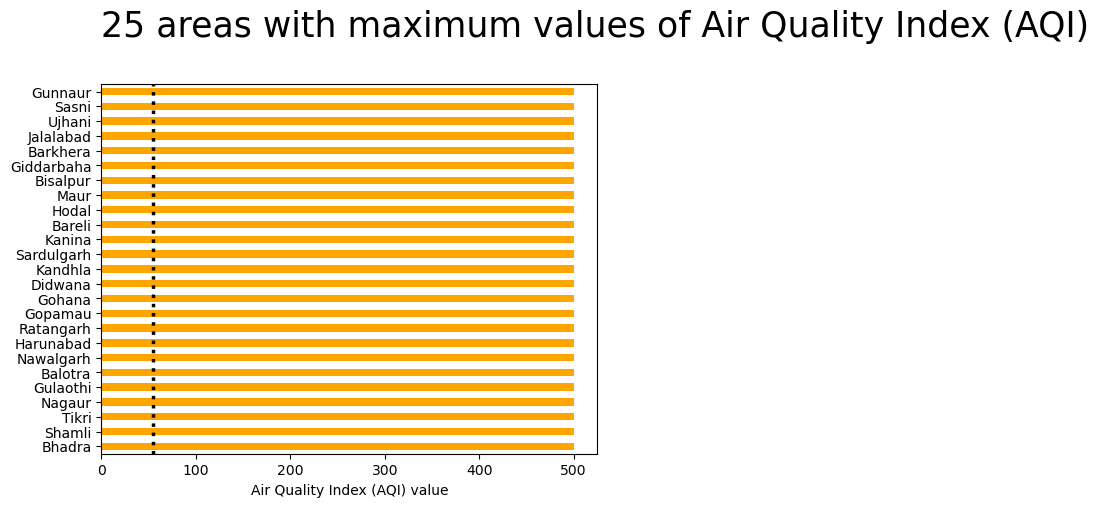

Air Quality Index (AQI)

White dotted line: 55.0 - median value for Air Quality Index (AQI) per city/area within the dataset.
This means, 50% of cities have no more than this.



aqi_value aqi_category
country  city                              
India    Bhadra          500.0    Hazardous
         Ujhani          500.0    Hazardous
         Jalalabad       500.0    Hazardous
         Barkhera        500.0    Hazardous
         Giddarbaha      500.0    Hazardous
         Bisalpur        500.0    Hazardous
         Maur            500.0    Hazardous
         Hodal           500.0    Hazardous
         Bareli          500.0    Hazardous
         Kanina          500.0    Hazardous
         Sardulgarh      500.0    Hazardous
         Sasni           500.0    Hazardous
         Kandhla         500.0    Hazardous
         Gohana          500.0    Hazardous
         Gopamau         500.0    Hazardous
         Ratangarh       500.0    Hazardous
Pakistan Harunabad       500.0    Hazardous
India    Nawalgarh       500.0    Hazardous
         Balotra         500.0    Hazardous
         Gulaothi        500.0    Hazardous
         Nagaur          500.0    Hazardous
         Tikri           500.0    Hazardous
         Shamli          500.0    Hazardous
         Didwana         500.0    Hazardous
         Gunnaur         500.0    Hazardous

In [22]:
# Define the column description list
column_description = [
    ('aqi', 'Air Quality Index (AQI)', 'Air Quality Index (AQI)'),
]

# Loop through each option in column_description
for option in column_description:
    # Use f-strings to request needed columns in the loop.
    column_1 = f'{option[0]}_value'
    column_2 = f'{option[0]}_category'
    
    # Make column name for title
    title_column = option[1]
    
    # Select only these 2 columns, sort values, and extract top 25 entries.
    max_aqi_df = countries_cities[[column_1, column_2]].sort_values(by=column_1, ascending=False).head(25)
    
    # Plot the numeric column.
    max_aqi_df.reset_index().sort_values(by=column_1, ascending=True).plot(
        kind='barh', x='city', y=column_1, color='orange', legend=False
    )
    
    # Add median value to the plot as a line.
    max_aqi_median = countries_cities[column_1].median()
    plt.axvline(x=max_aqi_median, ls=':', lw=2.5, color='black')
    
    # Set plot title, labels, and display the plot
    plt.title(f'25 areas with maximum values of {title_column}\n', fontsize=25, loc='left')
    plt.xlabel(f'{title_column} value')
    plt.ylabel('')
    plt.show()
    
    # Print description and summary information
    print(f'{option[2]}\n')
    print(f'White dotted line: {max_aqi_median} - median value for {title_column} per city/area within the dataset.')
    print('This means, 50% of cities have no more than this.\n')
    
    # Display the table
    display(max_aqi_df)
    
    

Countries with top 25 of the highest Air Quality Index (AQI) level:
- India
- Pakistan

The most polluted areas:
- Bhadra
- Ujhani
- Jalalabad
- Barkhera
- Giddarbaha

Categories for the selected 25 locations:
- Hazardous


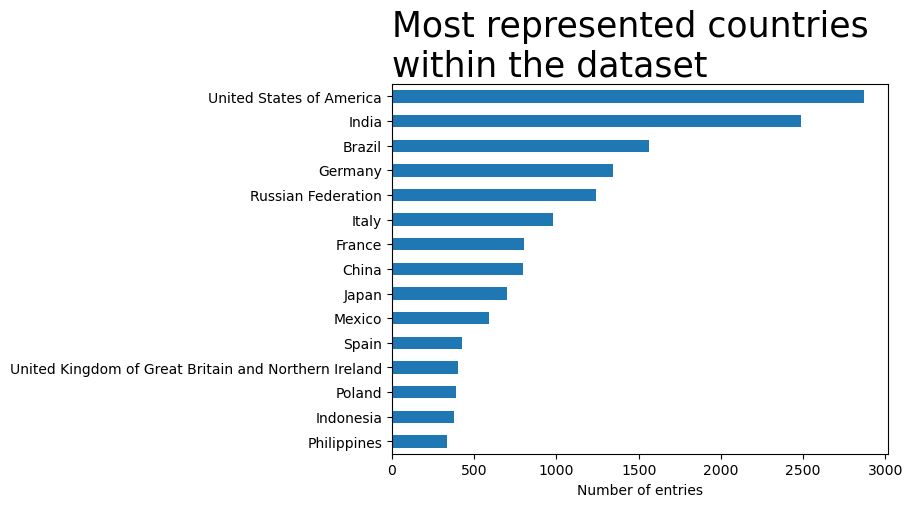

In [23]:
(
    air_pollution_df
    .groupby('country')
    # Count the rows: any column without missing values
    ['aqi_category'].count()
    # Sort values.
    .sort_values(ascending=False)
    # Extract the first 15.
    .head(15)
    # Sort values to have the commonest option at the top.
    .sort_values(ascending=True)
    # Plot the top 15.
    .plot(kind='barh')
)
plt.title('Most represented countries\nwithin the dataset', loc='left', fontsize=25)
# Remove the label for axis Y.
plt.ylabel('')
plt.xlabel('Number of entries')
plt.show()

In [24]:
# Checking values in depth: cities

# Overview the numbers of entries per city.
(
    air_pollution_df
    .groupby('city')
    # Count the rows: any column without missing values
    ['aqi_category'].count()
    # Show the statistics.
    .describe()
)

count    23035.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: aqi_category, dtype: float64

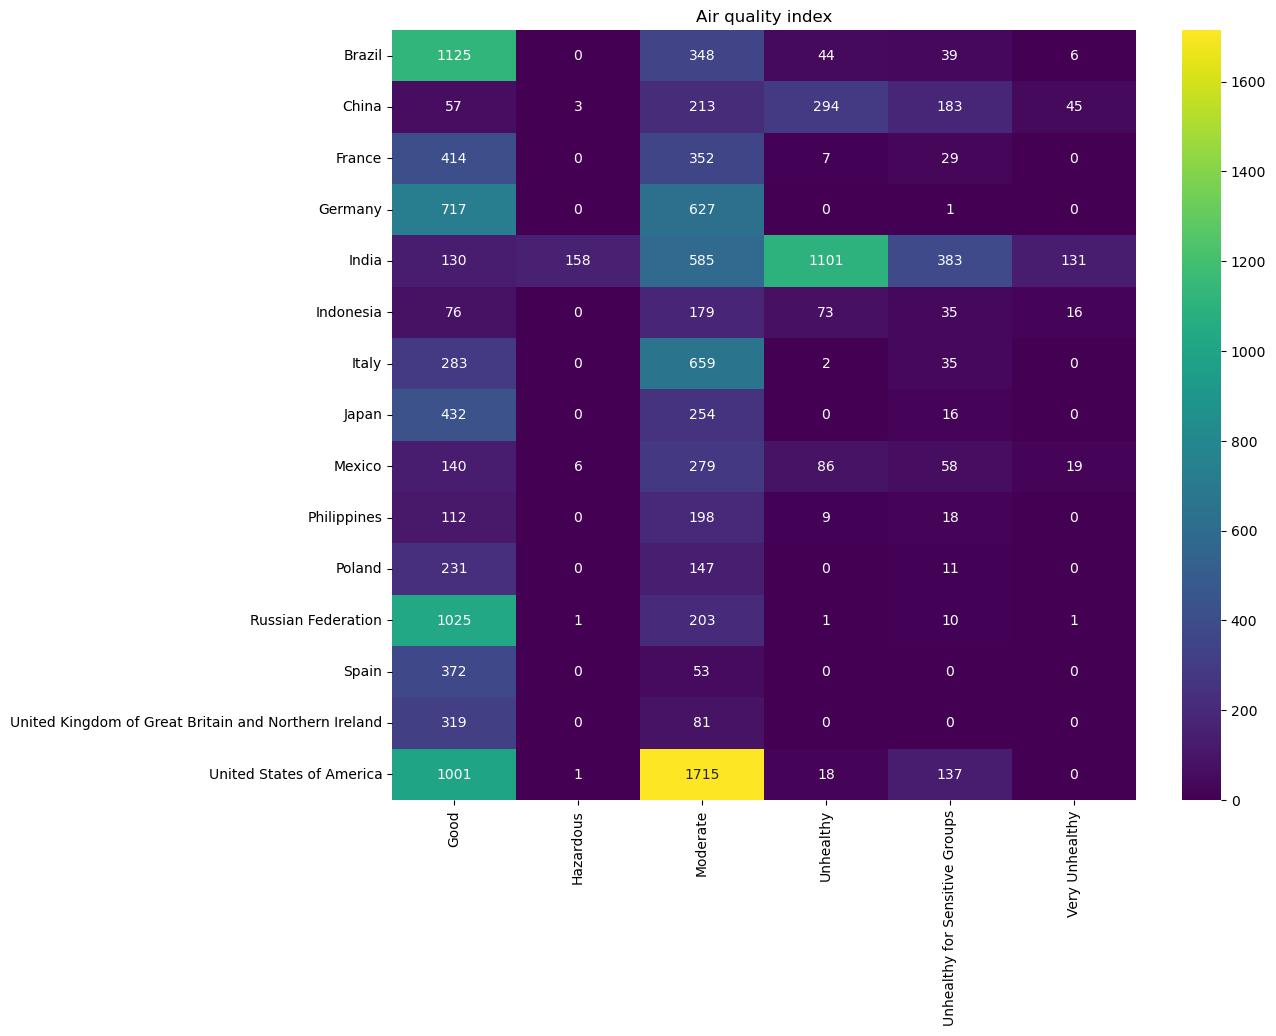

In [25]:
import seaborn as sns

# Function to create heatmap of cities per countries and their AQI categories
def make_heatmap_cities_per_countries_and_categories(list_of_countries, category_column, ylabel, xlabel, plttitle, palette):
    # Filter the DataFrame to include only rows where the country is in the list_of_countries
    filtered_df = air_pollution_df[air_pollution_df['country'].isin(list_of_countries)]
    
    # Pivot the DataFrame to have countries as rows and AQI categories as columns, with counts of cities as values
    pivot_df = filtered_df.pivot_table(index='country', columns=category_column, aggfunc='size', fill_value=0)
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot_df, annot=True, fmt='d', cmap=palette)
    plt.title(plttitle)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Generate top list of countries with high pollution levels
top_list = (air_pollution_df.groupby('country')['aqi_category']
                            .count()
                            .sort_values(ascending=False)
                            .head(15)
                            .index
                            .to_list())

# Create heatmap
make_heatmap_cities_per_countries_and_categories(
    list_of_countries=top_list,
    category_column='aqi_category',
    ylabel='',
    xlabel='',
    plttitle="Air quality index",
    palette='viridis'
)

